## import libraries

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from nipype.interfaces import afni
from nipype.interfaces import fsl
import numpy as np
from nipype.interfaces.fsl import Smooth
import os
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import ImageMeants
import statsmodels.formula.api as smf
import seaborn as sns

from nipype.interfaces.fsl.model import Level1Design
from nipype.interfaces.fsl.model import FEAT

## set directories

In [77]:
data_dir = '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/cartoon_recall_fmriprep_2020/fmriprep/'
analysis_dir = '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/'

## set variables

In [78]:
subj_list = pd.read_excel('/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM_2020/subjlist.xlsx')
movie_list = ['barmaid','bluestreets']
event_boundaries = pd.read_excel('/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM/fmri_recall_event_boundaries_all.xlsx')

## smooth fMRIprep preprocessed 

In [9]:
#bluestreets
sm = Smooth()
sm.inputs.output_type = 'NIFTI_GZ'
sm.inputs.fwhm = 8.0

for j, sub in subj_list.iterrows():
    in_fname = data_dir+sub['subj_id']+'/'+sub['bluestreets_ses']+'/func/'+sub['subj_id']+'_'+sub['bluestreets_ses']+'_task-movieviewing_'+ sub['bluestreets_place']+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    out_fname = analysis_dir+'smoothed_images/'+sub['subj_id']+'bluestreets_smoothed.nii.gz'
    sm.inputs.in_file = in_fname
    sm.smoothed_file = out_fname
    sm.run() 

In [126]:
os.chdir(analysis_dir)
#barmaid
sm = Smooth()
sm.inputs.output_type = 'NIFTI_GZ'
sm.inputs.fwhm = 8.0

for j, sub in subj_list.iterrows():
    in_fname = data_dir+sub['subj_id']+'/'+sub['barmaid_ses']+'/func/'+sub['subj_id']+'_'+sub['barmaid_ses']+'_task-movieviewing_'+ sub['barmaid_place']+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    out_fname = analysis_dir+'smoothed_images/'+sub['subj_id']+'barmaid_smoothed.nii.gz'
    sm.inputs.in_file = in_fname
    sm.smoothed_file = out_fname
    sm.run() 

## extract motion regressors

In [129]:
for i, sub in subj_list.iterrows():
    #load in confounds and select relevant columns
    confound_full = pd.read_csv(data_dir+sub['subj_id']+'/'+sub['barmaid_ses']+'/func/'+sub['subj_id']+'_'+sub['barmaid_ses']+'_task-movieviewing_'+ sub['barmaid_place']+ '_desc-confounds_regressors.tsv', sep='\t')
    index = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
    confound_motion_outliers = confound_full.filter(regex="motion_outlier")
    confound_motion = confound_full[index]
    confound_select = pd.concat([confound_motion_outliers,confound_motion],axis = 1)
    confound_select.to_csv(data_dir+sub['subj_id']+'/'+sub['barmaid_ses']+'/func/'+sub['subj_id']+'_'+sub['barmaid_ses']+'_task-movieviewing_'+ sub['barmaid_place']+ '_desc-confounds_regressors_select.csv', header=False, index= False,sep = ' ')
   

In [32]:
for i, sub in subj_list.iterrows():
    #load in confounds and select relevant columns
    confound_full = pd.read_csv(data_dir+sub['subj_id']+'/'+sub['bluestreets_ses']+'/func/'+sub['subj_id']+'_'+sub['bluestreets_ses']+'_task-movieviewing_'+ sub['bluestreets_place']+ '_desc-confounds_regressors.tsv', sep='\t')
    index = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
    confound_motion_outliers = confound_full.filter(regex="motion_outlier")
    confound_motion = confound_full[index]
    confound_select = pd.concat([confound_motion,confound_motion_outliers],axis = 1)
    confound_select.to_csv(data_dir+sub['subj_id']+'/'+sub['bluestreets_ses']+'/func/'+sub['subj_id']+'_'+sub['bluestreets_ses']+'_task-movieviewing_'+ sub['bluestreets_place']+ '_desc-confounds_regressors_select.csv', header=False, index= False,sep = ' ')
 

## specify model

In [79]:
barmaid_boundaries = np.array([58,    97,    160,   189,   300, 350, 465, 507, 552, 619, 695, 772, 871, 1004])
bluestreets_boundaries = np.array([45, 75,   150,   226,   307, 381, 444, 526, 578, 665, 756, 828, 853,982])

barmaid_middles = np.array([29,77.5,128.5,170.5,240.5,325,413,491.5,530,586,657,733.5,821.5,939])
bluestreets_middles = np.array([22.5,60,112.5,188,266.5,344,412.5,485,552,621.5,710.5,792,840.5,917.5])

## create bluestreets session info

In [81]:
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

os.chdir(analysis_dir)
s = modelgen.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.time_repetition = 1.22
s.inputs.high_pass_filter_cutoff = 128.
evs = Bunch(conditions=['boundary','middle'], onsets=[bluestreets_boundaries,bluestreets_middles], durations=[[0],[0]])
for j, sub in subj_list.iterrows():
    #os.mkdir(sub['subj_id'])
    os.chdir(sub['subj_id'])
    #os.mkdir('bluestreets')
    os.chdir('bluestreets')
    realign_params = data_dir+sub['subj_id']+'/'+sub['bluestreets_ses']+'/func/'+sub['subj_id']+'_'+sub['bluestreets_ses']+'_task-movieviewing_'+ sub['bluestreets_place']+ '_desc-confounds_regressors_select.csv'
    in_fname = analysis_dir+sub['subj_id']+'_'+sub['bluestreets_ses']+'_task-movieviewing_'+ sub['bluestreets_place']+'_space-MNI152NLin2009cAsym_desc-preproc_bold_smooth.nii.gz'
    s.inputs.functional_runs = in_fname
    s.inputs.realignment_parameters = realign_params
    s.inputs.subject_info = [evs]
    exec(str(s.run().outputs))
    np.save('session_info_bluestreets.npy',session_info)
    os.chdir(analysis_dir)

## create barmaid session info

In [82]:
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

os.chdir(analysis_dir)
s = modelgen.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.time_repetition = 1.22
s.inputs.high_pass_filter_cutoff = 128.
evs = Bunch(conditions=['boundary','middle'], onsets=[barmaid_boundaries,barmaid_middles], durations=[[0],[0]])
for j, sub in subj_list.iterrows():
    #os.mkdir(sub['subj_id'])
    os.chdir(sub['subj_id'])
    #os.mkdir('barmaid')
    os.chdir('barmaid')
    realign_params = data_dir+sub['subj_id']+'/'+sub['barmaid_ses']+'/func/'+sub['subj_id']+'_'+sub['barmaid_ses']+'_task-movieviewing_'+ sub['barmaid_place']+ '_desc-confounds_regressors_select.csv'
    in_fname = analysis_dir+sub['subj_id']+'_'+sub['barmaid_ses']+'_task-movieviewing_'+ sub['barmaid_place']+'_space-MNI152NLin2009cAsym_desc-preproc_bold_smooth.nii.gz'
    s.inputs.functional_runs = in_fname
    s.inputs.realignment_parameters = realign_params
    s.inputs.subject_info = [evs]
    exec(str(s.run().outputs))
    np.save('session_info_barmaid.npy',session_info)
    os.chdir(analysis_dir)

## set up lvl 1 fsf bluestreets

In [83]:
os.chdir(analysis_dir)

level1design = Level1Design()
level1design.inputs.interscan_interval = 1.22
level1design.inputs.model_serial_correlations = True
level1design.inputs.bases = {'dgamma':{'derivs': False}}
level1design.inputs.contrasts = [('boundary vs middle','T',['boundary','middle'],[1,-1]),('middle vs boundary','T',['boundary','middle'],[-1,1])]
for j, sub in subj_list.iterrows():
    os.chdir(sub['subj_id'])
    os.chdir('bluestreets')
    level1design.inputs.session_info = np.load('session_info_bluestreets.npy',allow_pickle=True)
    level1design.run()
    os.chdir(analysis_dir)

## set up lvl 1 fsf barmaid

In [84]:
os.chdir(analysis_dir)

level1design = Level1Design()
level1design.inputs.interscan_interval = 1.22
level1design.inputs.model_serial_correlations = True
level1design.inputs.bases = {'dgamma':{'derivs': False}}
level1design.inputs.contrasts = [('boundary vs middle','T',['boundary','middle'],[1,-1]),('middle vs boundary','T',['boundary','middle'],[-1,1])]
for j, sub in subj_list.iterrows():
    os.chdir(sub['subj_id'])
    os.chdir('barmaid')
    level1design.inputs.session_info = np.load('session_info_barmaid.npy',allow_pickle=True)
    level1design.run()
    os.chdir(analysis_dir)

## run FEAT from fsf file: bluestreets

In [85]:
os.chdir(analysis_dir)
ft = FEAT()
for j, sub in subj_list.iterrows():
    os.chdir(sub['subj_id'])
    os.chdir('bluestreets')
    ft.inputs.fsf_file = 'run0.fsf'
    ft.run()
    os.chdir(analysis_dir)

200806-06:56:23,781 nipype.interface INFO:
	 stdout 2020-08-06T06:56:23.781253:To view the FEAT progress and final report, point your web browser at /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-000/bluestreets/run0++.feat/report_log.html
Outputs from FEATmodel: {'feat_dir': '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-000/bluestreets/run0++.feat'}
200806-07:47:24,493 nipype.interface INFO:
	 stdout 2020-08-06T07:47:24.493141:To view the FEAT progress and final report, point your web browser at /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-101/bluestreets/run0++.feat/report_log.html
Outputs from FEATmodel: {'feat_dir': '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-101/bluestreets/run0++.feat'}
200806-08:23:32,715 nipype.interface INFO:
	 stdout 2020-08-06T08:23:32.714960:To view the FEAT progress and final report, point your web browser at /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-102/bluestreets/run0++.feat/report_log.html
Outputs from FE

## run FEAT from fsf file: barmaid

In [86]:
os.chdir(analysis_dir)
ft = FEAT()
for j, sub in subj_list.iterrows():
    os.chdir(sub['subj_id'])
    os.chdir('barmaid')
    ft.inputs.fsf_file = 'run0.fsf'
    ft.run()
    os.chdir(analysis_dir)

200806-21:25:00,195 nipype.interface INFO:
	 stdout 2020-08-06T21:25:00.195755:To view the FEAT progress and final report, point your web browser at /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-000/barmaid/run0++.feat/report_log.html
Outputs from FEATmodel: {'feat_dir': '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-000/barmaid/run0++.feat'}
200806-22:03:56,878 nipype.interface INFO:
	 stdout 2020-08-06T22:03:56.878721:To view the FEAT progress and final report, point your web browser at /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-101/barmaid/run0++.feat/report_log.html
Outputs from FEATmodel: {'feat_dir': '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-101/barmaid/run0++.feat'}
200806-22:40:31,127 nipype.interface INFO:
	 stdout 2020-08-06T22:40:31.127776:To view the FEAT progress and final report, point your web browser at /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-102/barmaid/run0++.feat/report_log.html
Outputs from FEATmodel: {'feat_dir'

## create 4D contrast of parameter estimate (COPE) images

In [110]:
#create file list for barmaid
!ls /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-*/barmaid/run0++.feat/stats/cope1.nii.gz > image_list.txt

with open('image_list.txt') as f:
    input_copes = f.readlines()
import re

regex = r"\n"
subst = ""

for i in range(len(input_copes)):
    input_copes[i]  = re.sub(regex, subst, input_copes[i], 0, re.MULTILINE) 

In [111]:
#create second level directory
os.chdir(analysis_dir)
#os.mkdir('barmaid_second_level')
os.chdir('barmaid_second_level')

#merge file list
merger = Merge()
merger.inputs.in_files = input_copes
merger.inputs.dimension = 't'
merger.inputs.output_type = 'NIFTI_GZ'
merger.run()

In [112]:
# run randomise
os.chdir(analysis_dir+'barmaid_second_level/')
import nipype.interfaces.fsl as fsl
rand = fsl.Randomise(in_file='cope1_merged.nii.gz', one_sample_group_mean=True,tfce=True,var_smooth=5)
rand.cmdline
rand.run()

200809-17:03:37,315 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.314971:randomise options: -i cope1_merged.nii.gz -o randomise -1 -T -v 5 
200809-17:03:37,497 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.497408:Loading Data: 
200809-17:03:37,498 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.497408:Data loaded
200809-17:03:37,528 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.527986:One-sample design detected; sign-flipping instead of permuting.
200809-17:03:37,528 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.527986:262144 sign-flips required for exhaustive test of t-test 1
200809-17:03:37,592 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.592315:Doing 5000 random permutations
200809-17:03:37,594 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.594181:Starting permutation 1 (Unpermuted data)
200809-17:03:37,853 nipype.interface INFO:
	 stdout 2020-08-09T17:03:37.853571:Starting permutation 2
200809-17:03:38,43 nipype.interface INFO:
	 stdout 2020-

200809-17:03:50,929 nipype.interface INFO:
	 stdout 2020-08-09T17:03:50.929788:Starting permutation 74
200809-17:03:51,104 nipype.interface INFO:
	 stdout 2020-08-09T17:03:51.104709:Starting permutation 75
200809-17:03:51,281 nipype.interface INFO:
	 stdout 2020-08-09T17:03:51.281761:Starting permutation 76
200809-17:03:51,455 nipype.interface INFO:
	 stdout 2020-08-09T17:03:51.455583:Starting permutation 77
200809-17:03:51,641 nipype.interface INFO:
	 stdout 2020-08-09T17:03:51.641602:Starting permutation 78
200809-17:03:51,836 nipype.interface INFO:
	 stdout 2020-08-09T17:03:51.836142:Starting permutation 79
200809-17:03:51,999 nipype.interface INFO:
	 stdout 2020-08-09T17:03:51.999635:Starting permutation 80
200809-17:03:52,189 nipype.interface INFO:
	 stdout 2020-08-09T17:03:52.189957:Starting permutation 81
200809-17:03:52,352 nipype.interface INFO:
	 stdout 2020-08-09T17:03:52.352191:Starting permutation 82
200809-17:03:52,515 nipype.interface INFO:
	 stdout 2020-08-09T17:03:52.5

200809-17:04:05,102 nipype.interface INFO:
	 stdout 2020-08-09T17:04:05.102281:Starting permutation 154
200809-17:04:05,273 nipype.interface INFO:
	 stdout 2020-08-09T17:04:05.273214:Starting permutation 155
200809-17:04:05,445 nipype.interface INFO:
	 stdout 2020-08-09T17:04:05.445602:Starting permutation 156
200809-17:04:05,629 nipype.interface INFO:
	 stdout 2020-08-09T17:04:05.629871:Starting permutation 157
200809-17:04:05,805 nipype.interface INFO:
	 stdout 2020-08-09T17:04:05.805214:Starting permutation 158
200809-17:04:05,979 nipype.interface INFO:
	 stdout 2020-08-09T17:04:05.979884:Starting permutation 159
200809-17:04:06,150 nipype.interface INFO:
	 stdout 2020-08-09T17:04:06.150246:Starting permutation 160
200809-17:04:06,334 nipype.interface INFO:
	 stdout 2020-08-09T17:04:06.334541:Starting permutation 161
200809-17:04:06,518 nipype.interface INFO:
	 stdout 2020-08-09T17:04:06.518393:Starting permutation 162
200809-17:04:06,708 nipype.interface INFO:
	 stdout 2020-08-09T1

200809-17:04:18,954 nipype.interface INFO:
	 stdout 2020-08-09T17:04:18.954383:Starting permutation 233
200809-17:04:19,114 nipype.interface INFO:
	 stdout 2020-08-09T17:04:19.114199:Starting permutation 234
200809-17:04:19,281 nipype.interface INFO:
	 stdout 2020-08-09T17:04:19.281727:Starting permutation 235
200809-17:04:19,458 nipype.interface INFO:
	 stdout 2020-08-09T17:04:19.458312:Starting permutation 236
200809-17:04:19,627 nipype.interface INFO:
	 stdout 2020-08-09T17:04:19.627513:Starting permutation 237
200809-17:04:19,807 nipype.interface INFO:
	 stdout 2020-08-09T17:04:19.807588:Starting permutation 238
200809-17:04:19,970 nipype.interface INFO:
	 stdout 2020-08-09T17:04:19.970904:Starting permutation 239
200809-17:04:20,136 nipype.interface INFO:
	 stdout 2020-08-09T17:04:20.136658:Starting permutation 240
200809-17:04:20,326 nipype.interface INFO:
	 stdout 2020-08-09T17:04:20.326065:Starting permutation 241
200809-17:04:20,496 nipype.interface INFO:
	 stdout 2020-08-09T1

200809-17:04:32,705 nipype.interface INFO:
	 stdout 2020-08-09T17:04:32.705830:Starting permutation 312
200809-17:04:32,880 nipype.interface INFO:
	 stdout 2020-08-09T17:04:32.880625:Starting permutation 313
200809-17:04:33,49 nipype.interface INFO:
	 stdout 2020-08-09T17:04:33.049834:Starting permutation 314
200809-17:04:33,215 nipype.interface INFO:
	 stdout 2020-08-09T17:04:33.215945:Starting permutation 315
200809-17:04:33,399 nipype.interface INFO:
	 stdout 2020-08-09T17:04:33.399154:Starting permutation 316
200809-17:04:33,559 nipype.interface INFO:
	 stdout 2020-08-09T17:04:33.559455:Starting permutation 317
200809-17:04:33,732 nipype.interface INFO:
	 stdout 2020-08-09T17:04:33.732418:Starting permutation 318
200809-17:04:33,921 nipype.interface INFO:
	 stdout 2020-08-09T17:04:33.921002:Starting permutation 319
200809-17:04:34,107 nipype.interface INFO:
	 stdout 2020-08-09T17:04:34.107357:Starting permutation 320
200809-17:04:34,275 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:04:46,430 nipype.interface INFO:
	 stdout 2020-08-09T17:04:46.430077:Starting permutation 391
200809-17:04:46,598 nipype.interface INFO:
	 stdout 2020-08-09T17:04:46.598891:Starting permutation 392
200809-17:04:46,769 nipype.interface INFO:
	 stdout 2020-08-09T17:04:46.769280:Starting permutation 393
200809-17:04:46,934 nipype.interface INFO:
	 stdout 2020-08-09T17:04:46.934153:Starting permutation 394
200809-17:04:47,101 nipype.interface INFO:
	 stdout 2020-08-09T17:04:47.101518:Starting permutation 395
200809-17:04:47,277 nipype.interface INFO:
	 stdout 2020-08-09T17:04:47.277297:Starting permutation 396
200809-17:04:47,439 nipype.interface INFO:
	 stdout 2020-08-09T17:04:47.439597:Starting permutation 397
200809-17:04:47,608 nipype.interface INFO:
	 stdout 2020-08-09T17:04:47.608214:Starting permutation 398
200809-17:04:47,771 nipype.interface INFO:
	 stdout 2020-08-09T17:04:47.771932:Starting permutation 399
200809-17:04:47,950 nipype.interface INFO:
	 stdout 2020-08-09T1

200809-17:05:00,124 nipype.interface INFO:
	 stdout 2020-08-09T17:05:00.124538:Starting permutation 470
200809-17:05:00,290 nipype.interface INFO:
	 stdout 2020-08-09T17:05:00.290298:Starting permutation 471
200809-17:05:00,447 nipype.interface INFO:
	 stdout 2020-08-09T17:05:00.447301:Starting permutation 472
200809-17:05:00,624 nipype.interface INFO:
	 stdout 2020-08-09T17:05:00.624389:Starting permutation 473
200809-17:05:00,793 nipype.interface INFO:
	 stdout 2020-08-09T17:05:00.793527:Starting permutation 474
200809-17:05:00,962 nipype.interface INFO:
	 stdout 2020-08-09T17:05:00.962602:Starting permutation 475
200809-17:05:01,136 nipype.interface INFO:
	 stdout 2020-08-09T17:05:01.136656:Starting permutation 476
200809-17:05:01,301 nipype.interface INFO:
	 stdout 2020-08-09T17:05:01.301550:Starting permutation 477
200809-17:05:01,476 nipype.interface INFO:
	 stdout 2020-08-09T17:05:01.476505:Starting permutation 478
200809-17:05:01,655 nipype.interface INFO:
	 stdout 2020-08-09T1

200809-17:05:13,961 nipype.interface INFO:
	 stdout 2020-08-09T17:05:13.961186:Starting permutation 549
200809-17:05:14,130 nipype.interface INFO:
	 stdout 2020-08-09T17:05:14.130732:Starting permutation 550
200809-17:05:14,299 nipype.interface INFO:
	 stdout 2020-08-09T17:05:14.299438:Starting permutation 551
200809-17:05:14,467 nipype.interface INFO:
	 stdout 2020-08-09T17:05:14.467087:Starting permutation 552
200809-17:05:14,624 nipype.interface INFO:
	 stdout 2020-08-09T17:05:14.624197:Starting permutation 553
200809-17:05:14,801 nipype.interface INFO:
	 stdout 2020-08-09T17:05:14.801387:Starting permutation 554
200809-17:05:14,973 nipype.interface INFO:
	 stdout 2020-08-09T17:05:14.973660:Starting permutation 555
200809-17:05:15,148 nipype.interface INFO:
	 stdout 2020-08-09T17:05:15.148225:Starting permutation 556
200809-17:05:15,325 nipype.interface INFO:
	 stdout 2020-08-09T17:05:15.325297:Starting permutation 557
200809-17:05:15,485 nipype.interface INFO:
	 stdout 2020-08-09T1

200809-17:05:27,695 nipype.interface INFO:
	 stdout 2020-08-09T17:05:27.695603:Starting permutation 628
200809-17:05:27,873 nipype.interface INFO:
	 stdout 2020-08-09T17:05:27.873903:Starting permutation 629
200809-17:05:28,40 nipype.interface INFO:
	 stdout 2020-08-09T17:05:28.040937:Starting permutation 630
200809-17:05:28,204 nipype.interface INFO:
	 stdout 2020-08-09T17:05:28.204776:Starting permutation 631
200809-17:05:28,376 nipype.interface INFO:
	 stdout 2020-08-09T17:05:28.376013:Starting permutation 632
200809-17:05:28,550 nipype.interface INFO:
	 stdout 2020-08-09T17:05:28.550488:Starting permutation 633
200809-17:05:28,737 nipype.interface INFO:
	 stdout 2020-08-09T17:05:28.737350:Starting permutation 634
200809-17:05:28,904 nipype.interface INFO:
	 stdout 2020-08-09T17:05:28.904536:Starting permutation 635
200809-17:05:29,61 nipype.interface INFO:
	 stdout 2020-08-09T17:05:29.061957:Starting permutation 636
200809-17:05:29,242 nipype.interface INFO:
	 stdout 2020-08-09T17:

200809-17:05:41,614 nipype.interface INFO:
	 stdout 2020-08-09T17:05:41.614154:Starting permutation 707
200809-17:05:41,789 nipype.interface INFO:
	 stdout 2020-08-09T17:05:41.789652:Starting permutation 708
200809-17:05:41,954 nipype.interface INFO:
	 stdout 2020-08-09T17:05:41.954283:Starting permutation 709
200809-17:05:42,151 nipype.interface INFO:
	 stdout 2020-08-09T17:05:42.151739:Starting permutation 710
200809-17:05:42,320 nipype.interface INFO:
	 stdout 2020-08-09T17:05:42.320388:Starting permutation 711
200809-17:05:42,487 nipype.interface INFO:
	 stdout 2020-08-09T17:05:42.487018:Starting permutation 712
200809-17:05:42,682 nipype.interface INFO:
	 stdout 2020-08-09T17:05:42.682676:Starting permutation 713
200809-17:05:42,863 nipype.interface INFO:
	 stdout 2020-08-09T17:05:42.863051:Starting permutation 714
200809-17:05:43,29 nipype.interface INFO:
	 stdout 2020-08-09T17:05:43.029153:Starting permutation 715
200809-17:05:43,202 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:05:55,386 nipype.interface INFO:
	 stdout 2020-08-09T17:05:55.386253:Starting permutation 786
200809-17:05:55,551 nipype.interface INFO:
	 stdout 2020-08-09T17:05:55.551710:Starting permutation 787
200809-17:05:55,722 nipype.interface INFO:
	 stdout 2020-08-09T17:05:55.722834:Starting permutation 788
200809-17:05:55,904 nipype.interface INFO:
	 stdout 2020-08-09T17:05:55.904251:Starting permutation 789
200809-17:05:56,76 nipype.interface INFO:
	 stdout 2020-08-09T17:05:56.076415:Starting permutation 790
200809-17:05:56,258 nipype.interface INFO:
	 stdout 2020-08-09T17:05:56.258847:Starting permutation 791
200809-17:05:56,428 nipype.interface INFO:
	 stdout 2020-08-09T17:05:56.428948:Starting permutation 792
200809-17:05:56,601 nipype.interface INFO:
	 stdout 2020-08-09T17:05:56.601400:Starting permutation 793
200809-17:05:56,777 nipype.interface INFO:
	 stdout 2020-08-09T17:05:56.777073:Starting permutation 794
200809-17:05:56,943 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:06:09,109 nipype.interface INFO:
	 stdout 2020-08-09T17:06:09.109548:Starting permutation 865
200809-17:06:09,270 nipype.interface INFO:
	 stdout 2020-08-09T17:06:09.270433:Starting permutation 866
200809-17:06:09,448 nipype.interface INFO:
	 stdout 2020-08-09T17:06:09.448722:Starting permutation 867
200809-17:06:09,624 nipype.interface INFO:
	 stdout 2020-08-09T17:06:09.624195:Starting permutation 868
200809-17:06:09,798 nipype.interface INFO:
	 stdout 2020-08-09T17:06:09.798200:Starting permutation 869
200809-17:06:09,966 nipype.interface INFO:
	 stdout 2020-08-09T17:06:09.966764:Starting permutation 870
200809-17:06:10,148 nipype.interface INFO:
	 stdout 2020-08-09T17:06:10.148701:Starting permutation 871
200809-17:06:10,328 nipype.interface INFO:
	 stdout 2020-08-09T17:06:10.328606:Starting permutation 872
200809-17:06:10,508 nipype.interface INFO:
	 stdout 2020-08-09T17:06:10.508311:Starting permutation 873
200809-17:06:10,692 nipype.interface INFO:
	 stdout 2020-08-09T1

200809-17:06:22,908 nipype.interface INFO:
	 stdout 2020-08-09T17:06:22.908543:Starting permutation 944
200809-17:06:23,72 nipype.interface INFO:
	 stdout 2020-08-09T17:06:23.072217:Starting permutation 945
200809-17:06:23,256 nipype.interface INFO:
	 stdout 2020-08-09T17:06:23.256349:Starting permutation 946
200809-17:06:23,432 nipype.interface INFO:
	 stdout 2020-08-09T17:06:23.432472:Starting permutation 947
200809-17:06:23,619 nipype.interface INFO:
	 stdout 2020-08-09T17:06:23.619655:Starting permutation 948
200809-17:06:23,793 nipype.interface INFO:
	 stdout 2020-08-09T17:06:23.793179:Starting permutation 949
200809-17:06:23,958 nipype.interface INFO:
	 stdout 2020-08-09T17:06:23.958749:Starting permutation 950
200809-17:06:24,127 nipype.interface INFO:
	 stdout 2020-08-09T17:06:24.127188:Starting permutation 951
200809-17:06:24,304 nipype.interface INFO:
	 stdout 2020-08-09T17:06:24.304304:Starting permutation 952
200809-17:06:24,495 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:06:36,741 nipype.interface INFO:
	 stdout 2020-08-09T17:06:36.741622:Starting permutation 1023
200809-17:06:36,917 nipype.interface INFO:
	 stdout 2020-08-09T17:06:36.917550:Starting permutation 1024
200809-17:06:37,88 nipype.interface INFO:
	 stdout 2020-08-09T17:06:37.088605:Starting permutation 1025
200809-17:06:37,262 nipype.interface INFO:
	 stdout 2020-08-09T17:06:37.262090:Starting permutation 1026
200809-17:06:37,429 nipype.interface INFO:
	 stdout 2020-08-09T17:06:37.428988:Starting permutation 1027
200809-17:06:37,592 nipype.interface INFO:
	 stdout 2020-08-09T17:06:37.592172:Starting permutation 1028
200809-17:06:37,792 nipype.interface INFO:
	 stdout 2020-08-09T17:06:37.792580:Starting permutation 1029
200809-17:06:37,960 nipype.interface INFO:
	 stdout 2020-08-09T17:06:37.960179:Starting permutation 1030
200809-17:06:38,146 nipype.interface INFO:
	 stdout 2020-08-09T17:06:38.146772:Starting permutation 1031
200809-17:06:38,323 nipype.interface INFO:
	 stdout 2020

200809-17:06:50,599 nipype.interface INFO:
	 stdout 2020-08-09T17:06:50.599934:Starting permutation 1102
200809-17:06:50,769 nipype.interface INFO:
	 stdout 2020-08-09T17:06:50.769906:Starting permutation 1103
200809-17:06:50,942 nipype.interface INFO:
	 stdout 2020-08-09T17:06:50.942390:Starting permutation 1104
200809-17:06:51,115 nipype.interface INFO:
	 stdout 2020-08-09T17:06:51.115686:Starting permutation 1105
200809-17:06:51,284 nipype.interface INFO:
	 stdout 2020-08-09T17:06:51.284515:Starting permutation 1106
200809-17:06:51,458 nipype.interface INFO:
	 stdout 2020-08-09T17:06:51.458924:Starting permutation 1107
200809-17:06:51,626 nipype.interface INFO:
	 stdout 2020-08-09T17:06:51.626368:Starting permutation 1108
200809-17:06:51,797 nipype.interface INFO:
	 stdout 2020-08-09T17:06:51.797523:Starting permutation 1109
200809-17:06:51,985 nipype.interface INFO:
	 stdout 2020-08-09T17:06:51.985224:Starting permutation 1110
200809-17:06:52,161 nipype.interface INFO:
	 stdout 202

200809-17:07:04,358 nipype.interface INFO:
	 stdout 2020-08-09T17:07:04.358293:Starting permutation 1181
200809-17:07:04,526 nipype.interface INFO:
	 stdout 2020-08-09T17:07:04.526168:Starting permutation 1182
200809-17:07:04,703 nipype.interface INFO:
	 stdout 2020-08-09T17:07:04.703631:Starting permutation 1183
200809-17:07:04,864 nipype.interface INFO:
	 stdout 2020-08-09T17:07:04.864201:Starting permutation 1184
200809-17:07:05,31 nipype.interface INFO:
	 stdout 2020-08-09T17:07:05.031720:Starting permutation 1185
200809-17:07:05,217 nipype.interface INFO:
	 stdout 2020-08-09T17:07:05.217245:Starting permutation 1186
200809-17:07:05,389 nipype.interface INFO:
	 stdout 2020-08-09T17:07:05.389921:Starting permutation 1187
200809-17:07:05,556 nipype.interface INFO:
	 stdout 2020-08-09T17:07:05.556533:Starting permutation 1188
200809-17:07:05,718 nipype.interface INFO:
	 stdout 2020-08-09T17:07:05.718607:Starting permutation 1189
200809-17:07:05,906 nipype.interface INFO:
	 stdout 2020

200809-17:07:18,92 nipype.interface INFO:
	 stdout 2020-08-09T17:07:18.092625:Starting permutation 1260
200809-17:07:18,259 nipype.interface INFO:
	 stdout 2020-08-09T17:07:18.259330:Starting permutation 1261
200809-17:07:18,443 nipype.interface INFO:
	 stdout 2020-08-09T17:07:18.443858:Starting permutation 1262
200809-17:07:18,613 nipype.interface INFO:
	 stdout 2020-08-09T17:07:18.613936:Starting permutation 1263
200809-17:07:18,789 nipype.interface INFO:
	 stdout 2020-08-09T17:07:18.789602:Starting permutation 1264
200809-17:07:18,974 nipype.interface INFO:
	 stdout 2020-08-09T17:07:18.974011:Starting permutation 1265
200809-17:07:19,154 nipype.interface INFO:
	 stdout 2020-08-09T17:07:19.154181:Starting permutation 1266
200809-17:07:19,335 nipype.interface INFO:
	 stdout 2020-08-09T17:07:19.335169:Starting permutation 1267
200809-17:07:19,511 nipype.interface INFO:
	 stdout 2020-08-09T17:07:19.511402:Starting permutation 1268
200809-17:07:19,685 nipype.interface INFO:
	 stdout 2020

200809-17:07:31,980 nipype.interface INFO:
	 stdout 2020-08-09T17:07:31.980827:Starting permutation 1339
200809-17:07:32,149 nipype.interface INFO:
	 stdout 2020-08-09T17:07:32.149948:Starting permutation 1340
200809-17:07:32,308 nipype.interface INFO:
	 stdout 2020-08-09T17:07:32.308428:Starting permutation 1341
200809-17:07:32,481 nipype.interface INFO:
	 stdout 2020-08-09T17:07:32.481063:Starting permutation 1342
200809-17:07:32,644 nipype.interface INFO:
	 stdout 2020-08-09T17:07:32.644914:Starting permutation 1343
200809-17:07:32,847 nipype.interface INFO:
	 stdout 2020-08-09T17:07:32.847269:Starting permutation 1344
200809-17:07:33,14 nipype.interface INFO:
	 stdout 2020-08-09T17:07:33.014922:Starting permutation 1345
200809-17:07:33,191 nipype.interface INFO:
	 stdout 2020-08-09T17:07:33.191027:Starting permutation 1346
200809-17:07:33,359 nipype.interface INFO:
	 stdout 2020-08-09T17:07:33.358967:Starting permutation 1347
200809-17:07:33,520 nipype.interface INFO:
	 stdout 2020

200809-17:07:45,667 nipype.interface INFO:
	 stdout 2020-08-09T17:07:45.667420:Starting permutation 1418
200809-17:07:45,863 nipype.interface INFO:
	 stdout 2020-08-09T17:07:45.863078:Starting permutation 1419
200809-17:07:46,28 nipype.interface INFO:
	 stdout 2020-08-09T17:07:46.028693:Starting permutation 1420
200809-17:07:46,200 nipype.interface INFO:
	 stdout 2020-08-09T17:07:46.200398:Starting permutation 1421
200809-17:07:46,387 nipype.interface INFO:
	 stdout 2020-08-09T17:07:46.387306:Starting permutation 1422
200809-17:07:46,563 nipype.interface INFO:
	 stdout 2020-08-09T17:07:46.563380:Starting permutation 1423
200809-17:07:46,723 nipype.interface INFO:
	 stdout 2020-08-09T17:07:46.722979:Starting permutation 1424
200809-17:07:46,895 nipype.interface INFO:
	 stdout 2020-08-09T17:07:46.895515:Starting permutation 1425
200809-17:07:47,54 nipype.interface INFO:
	 stdout 2020-08-09T17:07:47.054425:Starting permutation 1426
200809-17:07:47,226 nipype.interface INFO:
	 stdout 2020-

200809-17:07:59,413 nipype.interface INFO:
	 stdout 2020-08-09T17:07:59.413133:Starting permutation 1497
200809-17:07:59,584 nipype.interface INFO:
	 stdout 2020-08-09T17:07:59.584452:Starting permutation 1498
200809-17:07:59,745 nipype.interface INFO:
	 stdout 2020-08-09T17:07:59.745559:Starting permutation 1499
200809-17:07:59,927 nipype.interface INFO:
	 stdout 2020-08-09T17:07:59.927038:Starting permutation 1500
200809-17:08:00,99 nipype.interface INFO:
	 stdout 2020-08-09T17:08:00.099915:Starting permutation 1501
200809-17:08:00,264 nipype.interface INFO:
	 stdout 2020-08-09T17:08:00.264343:Starting permutation 1502
200809-17:08:00,431 nipype.interface INFO:
	 stdout 2020-08-09T17:08:00.431162:Starting permutation 1503
200809-17:08:00,597 nipype.interface INFO:
	 stdout 2020-08-09T17:08:00.597248:Starting permutation 1504
200809-17:08:00,769 nipype.interface INFO:
	 stdout 2020-08-09T17:08:00.769423:Starting permutation 1505
200809-17:08:00,933 nipype.interface INFO:
	 stdout 2020

200809-17:08:13,217 nipype.interface INFO:
	 stdout 2020-08-09T17:08:13.217633:Starting permutation 1576
200809-17:08:13,382 nipype.interface INFO:
	 stdout 2020-08-09T17:08:13.382365:Starting permutation 1577
200809-17:08:13,562 nipype.interface INFO:
	 stdout 2020-08-09T17:08:13.562843:Starting permutation 1578
200809-17:08:13,727 nipype.interface INFO:
	 stdout 2020-08-09T17:08:13.726980:Starting permutation 1579
200809-17:08:13,914 nipype.interface INFO:
	 stdout 2020-08-09T17:08:13.914449:Starting permutation 1580
200809-17:08:14,77 nipype.interface INFO:
	 stdout 2020-08-09T17:08:14.077609:Starting permutation 1581
200809-17:08:14,256 nipype.interface INFO:
	 stdout 2020-08-09T17:08:14.256753:Starting permutation 1582
200809-17:08:14,417 nipype.interface INFO:
	 stdout 2020-08-09T17:08:14.417892:Starting permutation 1583
200809-17:08:14,614 nipype.interface INFO:
	 stdout 2020-08-09T17:08:14.614222:Starting permutation 1584
200809-17:08:14,773 nipype.interface INFO:
	 stdout 2020

200809-17:08:27,36 nipype.interface INFO:
	 stdout 2020-08-09T17:08:27.036793:Starting permutation 1655
200809-17:08:27,208 nipype.interface INFO:
	 stdout 2020-08-09T17:08:27.208068:Starting permutation 1656
200809-17:08:27,378 nipype.interface INFO:
	 stdout 2020-08-09T17:08:27.378733:Starting permutation 1657
200809-17:08:27,548 nipype.interface INFO:
	 stdout 2020-08-09T17:08:27.548395:Starting permutation 1658
200809-17:08:27,734 nipype.interface INFO:
	 stdout 2020-08-09T17:08:27.734291:Starting permutation 1659
200809-17:08:27,905 nipype.interface INFO:
	 stdout 2020-08-09T17:08:27.905647:Starting permutation 1660
200809-17:08:28,83 nipype.interface INFO:
	 stdout 2020-08-09T17:08:28.083096:Starting permutation 1661
200809-17:08:28,266 nipype.interface INFO:
	 stdout 2020-08-09T17:08:28.266519:Starting permutation 1662
200809-17:08:28,428 nipype.interface INFO:
	 stdout 2020-08-09T17:08:28.428374:Starting permutation 1663
200809-17:08:28,600 nipype.interface INFO:
	 stdout 2020-

200809-17:08:40,933 nipype.interface INFO:
	 stdout 2020-08-09T17:08:40.933681:Starting permutation 1734
200809-17:08:41,99 nipype.interface INFO:
	 stdout 2020-08-09T17:08:41.099962:Starting permutation 1735
200809-17:08:41,272 nipype.interface INFO:
	 stdout 2020-08-09T17:08:41.272571:Starting permutation 1736
200809-17:08:41,439 nipype.interface INFO:
	 stdout 2020-08-09T17:08:41.439466:Starting permutation 1737
200809-17:08:41,607 nipype.interface INFO:
	 stdout 2020-08-09T17:08:41.607877:Starting permutation 1738
200809-17:08:41,777 nipype.interface INFO:
	 stdout 2020-08-09T17:08:41.777475:Starting permutation 1739
200809-17:08:41,943 nipype.interface INFO:
	 stdout 2020-08-09T17:08:41.943730:Starting permutation 1740
200809-17:08:42,106 nipype.interface INFO:
	 stdout 2020-08-09T17:08:42.106912:Starting permutation 1741
200809-17:08:42,282 nipype.interface INFO:
	 stdout 2020-08-09T17:08:42.282094:Starting permutation 1742
200809-17:08:42,450 nipype.interface INFO:
	 stdout 2020

200809-17:08:54,675 nipype.interface INFO:
	 stdout 2020-08-09T17:08:54.675816:Starting permutation 1813
200809-17:08:54,841 nipype.interface INFO:
	 stdout 2020-08-09T17:08:54.841794:Starting permutation 1814
200809-17:08:55,10 nipype.interface INFO:
	 stdout 2020-08-09T17:08:55.010184:Starting permutation 1815
200809-17:08:55,176 nipype.interface INFO:
	 stdout 2020-08-09T17:08:55.176790:Starting permutation 1816
200809-17:08:55,346 nipype.interface INFO:
	 stdout 2020-08-09T17:08:55.346625:Starting permutation 1817
200809-17:08:55,510 nipype.interface INFO:
	 stdout 2020-08-09T17:08:55.510433:Starting permutation 1818
200809-17:08:55,690 nipype.interface INFO:
	 stdout 2020-08-09T17:08:55.690868:Starting permutation 1819
200809-17:08:55,871 nipype.interface INFO:
	 stdout 2020-08-09T17:08:55.871199:Starting permutation 1820
200809-17:08:56,48 nipype.interface INFO:
	 stdout 2020-08-09T17:08:56.048074:Starting permutation 1821
200809-17:08:56,213 nipype.interface INFO:
	 stdout 2020-

200809-17:09:08,446 nipype.interface INFO:
	 stdout 2020-08-09T17:09:08.446627:Starting permutation 1892
200809-17:09:08,615 nipype.interface INFO:
	 stdout 2020-08-09T17:09:08.615074:Starting permutation 1893
200809-17:09:08,793 nipype.interface INFO:
	 stdout 2020-08-09T17:09:08.793633:Starting permutation 1894
200809-17:09:08,970 nipype.interface INFO:
	 stdout 2020-08-09T17:09:08.970669:Starting permutation 1895
200809-17:09:09,142 nipype.interface INFO:
	 stdout 2020-08-09T17:09:09.142134:Starting permutation 1896
200809-17:09:09,317 nipype.interface INFO:
	 stdout 2020-08-09T17:09:09.317087:Starting permutation 1897
200809-17:09:09,477 nipype.interface INFO:
	 stdout 2020-08-09T17:09:09.477235:Starting permutation 1898
200809-17:09:09,636 nipype.interface INFO:
	 stdout 2020-08-09T17:09:09.636285:Starting permutation 1899
200809-17:09:09,808 nipype.interface INFO:
	 stdout 2020-08-09T17:09:09.808928:Starting permutation 1900
200809-17:09:09,993 nipype.interface INFO:
	 stdout 202

200809-17:09:22,234 nipype.interface INFO:
	 stdout 2020-08-09T17:09:22.234195:Starting permutation 1971
200809-17:09:22,425 nipype.interface INFO:
	 stdout 2020-08-09T17:09:22.425263:Starting permutation 1972
200809-17:09:22,600 nipype.interface INFO:
	 stdout 2020-08-09T17:09:22.600601:Starting permutation 1973
200809-17:09:22,773 nipype.interface INFO:
	 stdout 2020-08-09T17:09:22.773361:Starting permutation 1974
200809-17:09:22,938 nipype.interface INFO:
	 stdout 2020-08-09T17:09:22.938951:Starting permutation 1975
200809-17:09:23,106 nipype.interface INFO:
	 stdout 2020-08-09T17:09:23.106046:Starting permutation 1976
200809-17:09:23,273 nipype.interface INFO:
	 stdout 2020-08-09T17:09:23.273337:Starting permutation 1977
200809-17:09:23,446 nipype.interface INFO:
	 stdout 2020-08-09T17:09:23.446622:Starting permutation 1978
200809-17:09:23,642 nipype.interface INFO:
	 stdout 2020-08-09T17:09:23.642181:Starting permutation 1979
200809-17:09:23,814 nipype.interface INFO:
	 stdout 202

200809-17:09:35,999 nipype.interface INFO:
	 stdout 2020-08-09T17:09:35.999680:Starting permutation 2050
200809-17:09:36,188 nipype.interface INFO:
	 stdout 2020-08-09T17:09:36.188891:Starting permutation 2051
200809-17:09:36,370 nipype.interface INFO:
	 stdout 2020-08-09T17:09:36.370118:Starting permutation 2052
200809-17:09:36,533 nipype.interface INFO:
	 stdout 2020-08-09T17:09:36.533556:Starting permutation 2053
200809-17:09:36,696 nipype.interface INFO:
	 stdout 2020-08-09T17:09:36.696078:Starting permutation 2054
200809-17:09:36,871 nipype.interface INFO:
	 stdout 2020-08-09T17:09:36.871144:Starting permutation 2055
200809-17:09:37,46 nipype.interface INFO:
	 stdout 2020-08-09T17:09:37.046013:Starting permutation 2056
200809-17:09:37,253 nipype.interface INFO:
	 stdout 2020-08-09T17:09:37.253096:Starting permutation 2057
200809-17:09:37,416 nipype.interface INFO:
	 stdout 2020-08-09T17:09:37.416615:Starting permutation 2058
200809-17:09:37,590 nipype.interface INFO:
	 stdout 2020

200809-17:09:49,756 nipype.interface INFO:
	 stdout 2020-08-09T17:09:49.756616:Starting permutation 2129
200809-17:09:49,936 nipype.interface INFO:
	 stdout 2020-08-09T17:09:49.936096:Starting permutation 2130
200809-17:09:50,123 nipype.interface INFO:
	 stdout 2020-08-09T17:09:50.123586:Starting permutation 2131
200809-17:09:50,288 nipype.interface INFO:
	 stdout 2020-08-09T17:09:50.288113:Starting permutation 2132
200809-17:09:50,471 nipype.interface INFO:
	 stdout 2020-08-09T17:09:50.471096:Starting permutation 2133
200809-17:09:50,647 nipype.interface INFO:
	 stdout 2020-08-09T17:09:50.647098:Starting permutation 2134
200809-17:09:50,822 nipype.interface INFO:
	 stdout 2020-08-09T17:09:50.822316:Starting permutation 2135
200809-17:09:50,987 nipype.interface INFO:
	 stdout 2020-08-09T17:09:50.987316:Starting permutation 2136
200809-17:09:51,151 nipype.interface INFO:
	 stdout 2020-08-09T17:09:51.151147:Starting permutation 2137
200809-17:09:51,328 nipype.interface INFO:
	 stdout 202

200809-17:10:03,561 nipype.interface INFO:
	 stdout 2020-08-09T17:10:03.561892:Starting permutation 2208
200809-17:10:03,738 nipype.interface INFO:
	 stdout 2020-08-09T17:10:03.738223:Starting permutation 2209
200809-17:10:03,921 nipype.interface INFO:
	 stdout 2020-08-09T17:10:03.921181:Starting permutation 2210
200809-17:10:04,96 nipype.interface INFO:
	 stdout 2020-08-09T17:10:04.096029:Starting permutation 2211
200809-17:10:04,292 nipype.interface INFO:
	 stdout 2020-08-09T17:10:04.292523:Starting permutation 2212
200809-17:10:04,473 nipype.interface INFO:
	 stdout 2020-08-09T17:10:04.473666:Starting permutation 2213
200809-17:10:04,643 nipype.interface INFO:
	 stdout 2020-08-09T17:10:04.643314:Starting permutation 2214
200809-17:10:04,805 nipype.interface INFO:
	 stdout 2020-08-09T17:10:04.805189:Starting permutation 2215
200809-17:10:04,988 nipype.interface INFO:
	 stdout 2020-08-09T17:10:04.988830:Starting permutation 2216
200809-17:10:05,157 nipype.interface INFO:
	 stdout 2020

200809-17:10:17,304 nipype.interface INFO:
	 stdout 2020-08-09T17:10:17.304518:Starting permutation 2287
200809-17:10:17,482 nipype.interface INFO:
	 stdout 2020-08-09T17:10:17.482804:Starting permutation 2288
200809-17:10:17,676 nipype.interface INFO:
	 stdout 2020-08-09T17:10:17.676115:Starting permutation 2289
200809-17:10:17,848 nipype.interface INFO:
	 stdout 2020-08-09T17:10:17.848210:Starting permutation 2290
200809-17:10:18,29 nipype.interface INFO:
	 stdout 2020-08-09T17:10:18.029217:Starting permutation 2291
200809-17:10:18,191 nipype.interface INFO:
	 stdout 2020-08-09T17:10:18.191806:Starting permutation 2292
200809-17:10:18,373 nipype.interface INFO:
	 stdout 2020-08-09T17:10:18.373247:Starting permutation 2293
200809-17:10:18,537 nipype.interface INFO:
	 stdout 2020-08-09T17:10:18.537599:Starting permutation 2294
200809-17:10:18,701 nipype.interface INFO:
	 stdout 2020-08-09T17:10:18.701545:Starting permutation 2295
200809-17:10:18,867 nipype.interface INFO:
	 stdout 2020

200809-17:10:31,8 nipype.interface INFO:
	 stdout 2020-08-09T17:10:31.008010:Starting permutation 2366
200809-17:10:31,199 nipype.interface INFO:
	 stdout 2020-08-09T17:10:31.199187:Starting permutation 2367
200809-17:10:31,381 nipype.interface INFO:
	 stdout 2020-08-09T17:10:31.381795:Starting permutation 2368
200809-17:10:31,549 nipype.interface INFO:
	 stdout 2020-08-09T17:10:31.549632:Starting permutation 2369
200809-17:10:31,739 nipype.interface INFO:
	 stdout 2020-08-09T17:10:31.739750:Starting permutation 2370
200809-17:10:31,906 nipype.interface INFO:
	 stdout 2020-08-09T17:10:31.906443:Starting permutation 2371
200809-17:10:32,98 nipype.interface INFO:
	 stdout 2020-08-09T17:10:32.098119:Starting permutation 2372
200809-17:10:32,296 nipype.interface INFO:
	 stdout 2020-08-09T17:10:32.296928:Starting permutation 2373
200809-17:10:32,474 nipype.interface INFO:
	 stdout 2020-08-09T17:10:32.474371:Starting permutation 2374
200809-17:10:32,651 nipype.interface INFO:
	 stdout 2020-0

200809-17:10:44,782 nipype.interface INFO:
	 stdout 2020-08-09T17:10:44.782334:Starting permutation 2445
200809-17:10:44,975 nipype.interface INFO:
	 stdout 2020-08-09T17:10:44.975212:Starting permutation 2446
200809-17:10:45,139 nipype.interface INFO:
	 stdout 2020-08-09T17:10:45.139365:Starting permutation 2447
200809-17:10:45,310 nipype.interface INFO:
	 stdout 2020-08-09T17:10:45.310134:Starting permutation 2448
200809-17:10:45,503 nipype.interface INFO:
	 stdout 2020-08-09T17:10:45.503319:Starting permutation 2449
200809-17:10:45,672 nipype.interface INFO:
	 stdout 2020-08-09T17:10:45.672061:Starting permutation 2450
200809-17:10:45,832 nipype.interface INFO:
	 stdout 2020-08-09T17:10:45.832339:Starting permutation 2451
200809-17:10:46,9 nipype.interface INFO:
	 stdout 2020-08-09T17:10:46.009296:Starting permutation 2452
200809-17:10:46,177 nipype.interface INFO:
	 stdout 2020-08-09T17:10:46.177560:Starting permutation 2453
200809-17:10:46,344 nipype.interface INFO:
	 stdout 2020-

200809-17:10:58,542 nipype.interface INFO:
	 stdout 2020-08-09T17:10:58.542264:Starting permutation 2524
200809-17:10:58,726 nipype.interface INFO:
	 stdout 2020-08-09T17:10:58.726593:Starting permutation 2525
200809-17:10:58,885 nipype.interface INFO:
	 stdout 2020-08-09T17:10:58.885265:Starting permutation 2526
200809-17:10:59,70 nipype.interface INFO:
	 stdout 2020-08-09T17:10:59.070268:Starting permutation 2527
200809-17:10:59,231 nipype.interface INFO:
	 stdout 2020-08-09T17:10:59.231103:Starting permutation 2528
200809-17:10:59,405 nipype.interface INFO:
	 stdout 2020-08-09T17:10:59.405442:Starting permutation 2529
200809-17:10:59,564 nipype.interface INFO:
	 stdout 2020-08-09T17:10:59.564582:Starting permutation 2530
200809-17:10:59,755 nipype.interface INFO:
	 stdout 2020-08-09T17:10:59.755508:Starting permutation 2531
200809-17:10:59,931 nipype.interface INFO:
	 stdout 2020-08-09T17:10:59.931518:Starting permutation 2532
200809-17:11:00,97 nipype.interface INFO:
	 stdout 2020-

200809-17:11:12,456 nipype.interface INFO:
	 stdout 2020-08-09T17:11:12.456917:Starting permutation 2603
200809-17:11:12,623 nipype.interface INFO:
	 stdout 2020-08-09T17:11:12.623324:Starting permutation 2604
200809-17:11:12,794 nipype.interface INFO:
	 stdout 2020-08-09T17:11:12.794033:Starting permutation 2605
200809-17:11:12,976 nipype.interface INFO:
	 stdout 2020-08-09T17:11:12.976300:Starting permutation 2606
200809-17:11:13,155 nipype.interface INFO:
	 stdout 2020-08-09T17:11:13.155388:Starting permutation 2607
200809-17:11:13,326 nipype.interface INFO:
	 stdout 2020-08-09T17:11:13.326509:Starting permutation 2608
200809-17:11:13,492 nipype.interface INFO:
	 stdout 2020-08-09T17:11:13.492825:Starting permutation 2609
200809-17:11:13,689 nipype.interface INFO:
	 stdout 2020-08-09T17:11:13.689170:Starting permutation 2610
200809-17:11:13,885 nipype.interface INFO:
	 stdout 2020-08-09T17:11:13.885204:Starting permutation 2611
200809-17:11:14,62 nipype.interface INFO:
	 stdout 2020

200809-17:11:26,287 nipype.interface INFO:
	 stdout 2020-08-09T17:11:26.287719:Starting permutation 2682
200809-17:11:26,498 nipype.interface INFO:
	 stdout 2020-08-09T17:11:26.498501:Starting permutation 2683
200809-17:11:26,672 nipype.interface INFO:
	 stdout 2020-08-09T17:11:26.672255:Starting permutation 2684
200809-17:11:26,846 nipype.interface INFO:
	 stdout 2020-08-09T17:11:26.846093:Starting permutation 2685
200809-17:11:27,7 nipype.interface INFO:
	 stdout 2020-08-09T17:11:27.007136:Starting permutation 2686
200809-17:11:27,175 nipype.interface INFO:
	 stdout 2020-08-09T17:11:27.175945:Starting permutation 2687
200809-17:11:27,358 nipype.interface INFO:
	 stdout 2020-08-09T17:11:27.358278:Starting permutation 2688
200809-17:11:27,527 nipype.interface INFO:
	 stdout 2020-08-09T17:11:27.527630:Starting permutation 2689
200809-17:11:27,710 nipype.interface INFO:
	 stdout 2020-08-09T17:11:27.710934:Starting permutation 2690
200809-17:11:27,874 nipype.interface INFO:
	 stdout 2020-

200809-17:11:40,71 nipype.interface INFO:
	 stdout 2020-08-09T17:11:40.071289:Starting permutation 2761
200809-17:11:40,230 nipype.interface INFO:
	 stdout 2020-08-09T17:11:40.230566:Starting permutation 2762
200809-17:11:40,394 nipype.interface INFO:
	 stdout 2020-08-09T17:11:40.394338:Starting permutation 2763
200809-17:11:40,557 nipype.interface INFO:
	 stdout 2020-08-09T17:11:40.557264:Starting permutation 2764
200809-17:11:40,727 nipype.interface INFO:
	 stdout 2020-08-09T17:11:40.727522:Starting permutation 2765
200809-17:11:40,901 nipype.interface INFO:
	 stdout 2020-08-09T17:11:40.901059:Starting permutation 2766
200809-17:11:41,88 nipype.interface INFO:
	 stdout 2020-08-09T17:11:41.088332:Starting permutation 2767
200809-17:11:41,248 nipype.interface INFO:
	 stdout 2020-08-09T17:11:41.248547:Starting permutation 2768
200809-17:11:41,426 nipype.interface INFO:
	 stdout 2020-08-09T17:11:41.426193:Starting permutation 2769
200809-17:11:41,642 nipype.interface INFO:
	 stdout 2020-

200809-17:11:53,928 nipype.interface INFO:
	 stdout 2020-08-09T17:11:53.928342:Starting permutation 2840
200809-17:11:54,102 nipype.interface INFO:
	 stdout 2020-08-09T17:11:54.102345:Starting permutation 2841
200809-17:11:54,281 nipype.interface INFO:
	 stdout 2020-08-09T17:11:54.281561:Starting permutation 2842
200809-17:11:54,452 nipype.interface INFO:
	 stdout 2020-08-09T17:11:54.452752:Starting permutation 2843
200809-17:11:54,626 nipype.interface INFO:
	 stdout 2020-08-09T17:11:54.626958:Starting permutation 2844
200809-17:11:54,793 nipype.interface INFO:
	 stdout 2020-08-09T17:11:54.793675:Starting permutation 2845
200809-17:11:54,964 nipype.interface INFO:
	 stdout 2020-08-09T17:11:54.964465:Starting permutation 2846
200809-17:11:55,125 nipype.interface INFO:
	 stdout 2020-08-09T17:11:55.125842:Starting permutation 2847
200809-17:11:55,297 nipype.interface INFO:
	 stdout 2020-08-09T17:11:55.297578:Starting permutation 2848
200809-17:11:55,496 nipype.interface INFO:
	 stdout 202

200809-17:12:07,580 nipype.interface INFO:
	 stdout 2020-08-09T17:12:07.580560:Starting permutation 2919
200809-17:12:07,765 nipype.interface INFO:
	 stdout 2020-08-09T17:12:07.765829:Starting permutation 2920
200809-17:12:07,936 nipype.interface INFO:
	 stdout 2020-08-09T17:12:07.936684:Starting permutation 2921
200809-17:12:08,115 nipype.interface INFO:
	 stdout 2020-08-09T17:12:08.115680:Starting permutation 2922
200809-17:12:08,277 nipype.interface INFO:
	 stdout 2020-08-09T17:12:08.277015:Starting permutation 2923
200809-17:12:08,441 nipype.interface INFO:
	 stdout 2020-08-09T17:12:08.441125:Starting permutation 2924
200809-17:12:08,626 nipype.interface INFO:
	 stdout 2020-08-09T17:12:08.626903:Starting permutation 2925
200809-17:12:08,808 nipype.interface INFO:
	 stdout 2020-08-09T17:12:08.808737:Starting permutation 2926
200809-17:12:08,996 nipype.interface INFO:
	 stdout 2020-08-09T17:12:08.996426:Starting permutation 2927
200809-17:12:09,174 nipype.interface INFO:
	 stdout 202

200809-17:12:21,390 nipype.interface INFO:
	 stdout 2020-08-09T17:12:21.390744:Starting permutation 2998
200809-17:12:21,572 nipype.interface INFO:
	 stdout 2020-08-09T17:12:21.572844:Starting permutation 2999
200809-17:12:21,737 nipype.interface INFO:
	 stdout 2020-08-09T17:12:21.737191:Starting permutation 3000
200809-17:12:21,914 nipype.interface INFO:
	 stdout 2020-08-09T17:12:21.914385:Starting permutation 3001
200809-17:12:22,84 nipype.interface INFO:
	 stdout 2020-08-09T17:12:22.084344:Starting permutation 3002
200809-17:12:22,254 nipype.interface INFO:
	 stdout 2020-08-09T17:12:22.254330:Starting permutation 3003
200809-17:12:22,439 nipype.interface INFO:
	 stdout 2020-08-09T17:12:22.439901:Starting permutation 3004
200809-17:12:22,619 nipype.interface INFO:
	 stdout 2020-08-09T17:12:22.619664:Starting permutation 3005
200809-17:12:22,818 nipype.interface INFO:
	 stdout 2020-08-09T17:12:22.817975:Starting permutation 3006
200809-17:12:22,990 nipype.interface INFO:
	 stdout 2020

200809-17:12:35,223 nipype.interface INFO:
	 stdout 2020-08-09T17:12:35.223620:Starting permutation 3077
200809-17:12:35,401 nipype.interface INFO:
	 stdout 2020-08-09T17:12:35.401595:Starting permutation 3078
200809-17:12:35,565 nipype.interface INFO:
	 stdout 2020-08-09T17:12:35.565359:Starting permutation 3079
200809-17:12:35,740 nipype.interface INFO:
	 stdout 2020-08-09T17:12:35.740622:Starting permutation 3080
200809-17:12:35,910 nipype.interface INFO:
	 stdout 2020-08-09T17:12:35.910193:Starting permutation 3081
200809-17:12:36,103 nipype.interface INFO:
	 stdout 2020-08-09T17:12:36.103598:Starting permutation 3082
200809-17:12:36,295 nipype.interface INFO:
	 stdout 2020-08-09T17:12:36.295128:Starting permutation 3083
200809-17:12:36,492 nipype.interface INFO:
	 stdout 2020-08-09T17:12:36.492714:Starting permutation 3084
200809-17:12:36,675 nipype.interface INFO:
	 stdout 2020-08-09T17:12:36.675079:Starting permutation 3085
200809-17:12:36,860 nipype.interface INFO:
	 stdout 202

200809-17:12:49,88 nipype.interface INFO:
	 stdout 2020-08-09T17:12:49.088757:Starting permutation 3156
200809-17:12:49,254 nipype.interface INFO:
	 stdout 2020-08-09T17:12:49.254600:Starting permutation 3157
200809-17:12:49,422 nipype.interface INFO:
	 stdout 2020-08-09T17:12:49.422401:Starting permutation 3158
200809-17:12:49,606 nipype.interface INFO:
	 stdout 2020-08-09T17:12:49.606348:Starting permutation 3159
200809-17:12:49,773 nipype.interface INFO:
	 stdout 2020-08-09T17:12:49.773077:Starting permutation 3160
200809-17:12:49,941 nipype.interface INFO:
	 stdout 2020-08-09T17:12:49.941838:Starting permutation 3161
200809-17:12:50,110 nipype.interface INFO:
	 stdout 2020-08-09T17:12:50.110114:Starting permutation 3162
200809-17:12:50,296 nipype.interface INFO:
	 stdout 2020-08-09T17:12:50.296196:Starting permutation 3163
200809-17:12:50,472 nipype.interface INFO:
	 stdout 2020-08-09T17:12:50.472678:Starting permutation 3164
200809-17:12:50,654 nipype.interface INFO:
	 stdout 2020

200809-17:13:03,1 nipype.interface INFO:
	 stdout 2020-08-09T17:13:03.001515:Starting permutation 3235
200809-17:13:03,181 nipype.interface INFO:
	 stdout 2020-08-09T17:13:03.181664:Starting permutation 3236
200809-17:13:03,375 nipype.interface INFO:
	 stdout 2020-08-09T17:13:03.375127:Starting permutation 3237
200809-17:13:03,542 nipype.interface INFO:
	 stdout 2020-08-09T17:13:03.542901:Starting permutation 3238
200809-17:13:03,704 nipype.interface INFO:
	 stdout 2020-08-09T17:13:03.704581:Starting permutation 3239
200809-17:13:03,874 nipype.interface INFO:
	 stdout 2020-08-09T17:13:03.874426:Starting permutation 3240
200809-17:13:04,40 nipype.interface INFO:
	 stdout 2020-08-09T17:13:04.040368:Starting permutation 3241
200809-17:13:04,223 nipype.interface INFO:
	 stdout 2020-08-09T17:13:04.223690:Starting permutation 3242
200809-17:13:04,402 nipype.interface INFO:
	 stdout 2020-08-09T17:13:04.402198:Starting permutation 3243
200809-17:13:04,580 nipype.interface INFO:
	 stdout 2020-0

200809-17:13:16,685 nipype.interface INFO:
	 stdout 2020-08-09T17:13:16.685732:Starting permutation 3314
200809-17:13:16,846 nipype.interface INFO:
	 stdout 2020-08-09T17:13:16.846140:Starting permutation 3315
200809-17:13:17,24 nipype.interface INFO:
	 stdout 2020-08-09T17:13:17.024294:Starting permutation 3316
200809-17:13:17,197 nipype.interface INFO:
	 stdout 2020-08-09T17:13:17.197132:Starting permutation 3317
200809-17:13:17,366 nipype.interface INFO:
	 stdout 2020-08-09T17:13:17.365969:Starting permutation 3318
200809-17:13:17,533 nipype.interface INFO:
	 stdout 2020-08-09T17:13:17.533786:Starting permutation 3319
200809-17:13:17,699 nipype.interface INFO:
	 stdout 2020-08-09T17:13:17.699718:Starting permutation 3320
200809-17:13:17,877 nipype.interface INFO:
	 stdout 2020-08-09T17:13:17.877417:Starting permutation 3321
200809-17:13:18,58 nipype.interface INFO:
	 stdout 2020-08-09T17:13:18.058277:Starting permutation 3322
200809-17:13:18,230 nipype.interface INFO:
	 stdout 2020-

200809-17:13:30,410 nipype.interface INFO:
	 stdout 2020-08-09T17:13:30.410573:Starting permutation 3393
200809-17:13:30,582 nipype.interface INFO:
	 stdout 2020-08-09T17:13:30.582514:Starting permutation 3394
200809-17:13:30,760 nipype.interface INFO:
	 stdout 2020-08-09T17:13:30.760388:Starting permutation 3395
200809-17:13:30,920 nipype.interface INFO:
	 stdout 2020-08-09T17:13:30.920360:Starting permutation 3396
200809-17:13:31,91 nipype.interface INFO:
	 stdout 2020-08-09T17:13:31.091318:Starting permutation 3397
200809-17:13:31,269 nipype.interface INFO:
	 stdout 2020-08-09T17:13:31.269844:Starting permutation 3398
200809-17:13:31,442 nipype.interface INFO:
	 stdout 2020-08-09T17:13:31.442511:Starting permutation 3399
200809-17:13:31,620 nipype.interface INFO:
	 stdout 2020-08-09T17:13:31.620386:Starting permutation 3400
200809-17:13:31,784 nipype.interface INFO:
	 stdout 2020-08-09T17:13:31.784723:Starting permutation 3401
200809-17:13:31,966 nipype.interface INFO:
	 stdout 2020

200809-17:13:44,142 nipype.interface INFO:
	 stdout 2020-08-09T17:13:44.142850:Starting permutation 3472
200809-17:13:44,332 nipype.interface INFO:
	 stdout 2020-08-09T17:13:44.332563:Starting permutation 3473
200809-17:13:44,515 nipype.interface INFO:
	 stdout 2020-08-09T17:13:44.515749:Starting permutation 3474
200809-17:13:44,683 nipype.interface INFO:
	 stdout 2020-08-09T17:13:44.683617:Starting permutation 3475
200809-17:13:44,849 nipype.interface INFO:
	 stdout 2020-08-09T17:13:44.849908:Starting permutation 3476
200809-17:13:45,26 nipype.interface INFO:
	 stdout 2020-08-09T17:13:45.026785:Starting permutation 3477
200809-17:13:45,206 nipype.interface INFO:
	 stdout 2020-08-09T17:13:45.206664:Starting permutation 3478
200809-17:13:45,374 nipype.interface INFO:
	 stdout 2020-08-09T17:13:45.374612:Starting permutation 3479
200809-17:13:45,538 nipype.interface INFO:
	 stdout 2020-08-09T17:13:45.538395:Starting permutation 3480
200809-17:13:45,709 nipype.interface INFO:
	 stdout 2020

200809-17:13:58,115 nipype.interface INFO:
	 stdout 2020-08-09T17:13:58.115706:Starting permutation 3551
200809-17:13:58,298 nipype.interface INFO:
	 stdout 2020-08-09T17:13:58.298031:Starting permutation 3552
200809-17:13:58,459 nipype.interface INFO:
	 stdout 2020-08-09T17:13:58.459785:Starting permutation 3553
200809-17:13:58,655 nipype.interface INFO:
	 stdout 2020-08-09T17:13:58.655325:Starting permutation 3554
200809-17:13:58,829 nipype.interface INFO:
	 stdout 2020-08-09T17:13:58.829191:Starting permutation 3555
200809-17:13:59,0 nipype.interface INFO:
	 stdout 2020-08-09T17:13:59.000565:Starting permutation 3556
200809-17:13:59,165 nipype.interface INFO:
	 stdout 2020-08-09T17:13:59.164975:Starting permutation 3557
200809-17:13:59,348 nipype.interface INFO:
	 stdout 2020-08-09T17:13:59.348590:Starting permutation 3558
200809-17:13:59,520 nipype.interface INFO:
	 stdout 2020-08-09T17:13:59.520478:Starting permutation 3559
200809-17:13:59,697 nipype.interface INFO:
	 stdout 2020-

200809-17:14:12,43 nipype.interface INFO:
	 stdout 2020-08-09T17:14:12.043787:Starting permutation 3630
200809-17:14:12,215 nipype.interface INFO:
	 stdout 2020-08-09T17:14:12.215341:Starting permutation 3631
200809-17:14:12,398 nipype.interface INFO:
	 stdout 2020-08-09T17:14:12.398747:Starting permutation 3632
200809-17:14:12,575 nipype.interface INFO:
	 stdout 2020-08-09T17:14:12.575352:Starting permutation 3633
200809-17:14:12,740 nipype.interface INFO:
	 stdout 2020-08-09T17:14:12.740149:Starting permutation 3634
200809-17:14:12,912 nipype.interface INFO:
	 stdout 2020-08-09T17:14:12.911985:Starting permutation 3635
200809-17:14:13,85 nipype.interface INFO:
	 stdout 2020-08-09T17:14:13.085040:Starting permutation 3636
200809-17:14:13,272 nipype.interface INFO:
	 stdout 2020-08-09T17:14:13.272432:Starting permutation 3637
200809-17:14:13,435 nipype.interface INFO:
	 stdout 2020-08-09T17:14:13.435209:Starting permutation 3638
200809-17:14:13,620 nipype.interface INFO:
	 stdout 2020-

200809-17:14:25,722 nipype.interface INFO:
	 stdout 2020-08-09T17:14:25.721978:Starting permutation 3709
200809-17:14:25,890 nipype.interface INFO:
	 stdout 2020-08-09T17:14:25.890080:Starting permutation 3710
200809-17:14:26,64 nipype.interface INFO:
	 stdout 2020-08-09T17:14:26.064238:Starting permutation 3711
200809-17:14:26,246 nipype.interface INFO:
	 stdout 2020-08-09T17:14:26.246316:Starting permutation 3712
200809-17:14:26,417 nipype.interface INFO:
	 stdout 2020-08-09T17:14:26.417219:Starting permutation 3713
200809-17:14:26,586 nipype.interface INFO:
	 stdout 2020-08-09T17:14:26.586204:Starting permutation 3714
200809-17:14:26,759 nipype.interface INFO:
	 stdout 2020-08-09T17:14:26.759720:Starting permutation 3715
200809-17:14:26,937 nipype.interface INFO:
	 stdout 2020-08-09T17:14:26.937049:Starting permutation 3716
200809-17:14:27,129 nipype.interface INFO:
	 stdout 2020-08-09T17:14:27.129510:Starting permutation 3717
200809-17:14:27,298 nipype.interface INFO:
	 stdout 2020

200809-17:14:39,619 nipype.interface INFO:
	 stdout 2020-08-09T17:14:39.619282:Starting permutation 3788
200809-17:14:39,805 nipype.interface INFO:
	 stdout 2020-08-09T17:14:39.805220:Starting permutation 3789
200809-17:14:39,976 nipype.interface INFO:
	 stdout 2020-08-09T17:14:39.976053:Starting permutation 3790
200809-17:14:40,148 nipype.interface INFO:
	 stdout 2020-08-09T17:14:40.148119:Starting permutation 3791
200809-17:14:40,313 nipype.interface INFO:
	 stdout 2020-08-09T17:14:40.313573:Starting permutation 3792
200809-17:14:40,496 nipype.interface INFO:
	 stdout 2020-08-09T17:14:40.496398:Starting permutation 3793
200809-17:14:40,659 nipype.interface INFO:
	 stdout 2020-08-09T17:14:40.659217:Starting permutation 3794
200809-17:14:40,855 nipype.interface INFO:
	 stdout 2020-08-09T17:14:40.855125:Starting permutation 3795
200809-17:14:41,32 nipype.interface INFO:
	 stdout 2020-08-09T17:14:41.032705:Starting permutation 3796
200809-17:14:41,207 nipype.interface INFO:
	 stdout 2020

200809-17:14:53,443 nipype.interface INFO:
	 stdout 2020-08-09T17:14:53.443910:Starting permutation 3867
200809-17:14:53,613 nipype.interface INFO:
	 stdout 2020-08-09T17:14:53.613187:Starting permutation 3868
200809-17:14:53,786 nipype.interface INFO:
	 stdout 2020-08-09T17:14:53.786947:Starting permutation 3869
200809-17:14:53,950 nipype.interface INFO:
	 stdout 2020-08-09T17:14:53.950501:Starting permutation 3870
200809-17:14:54,116 nipype.interface INFO:
	 stdout 2020-08-09T17:14:54.116451:Starting permutation 3871
200809-17:14:54,286 nipype.interface INFO:
	 stdout 2020-08-09T17:14:54.286749:Starting permutation 3872
200809-17:14:54,468 nipype.interface INFO:
	 stdout 2020-08-09T17:14:54.468143:Starting permutation 3873
200809-17:14:54,632 nipype.interface INFO:
	 stdout 2020-08-09T17:14:54.632785:Starting permutation 3874
200809-17:14:54,797 nipype.interface INFO:
	 stdout 2020-08-09T17:14:54.797721:Starting permutation 3875
200809-17:14:54,991 nipype.interface INFO:
	 stdout 202

200809-17:15:07,311 nipype.interface INFO:
	 stdout 2020-08-09T17:15:07.311571:Starting permutation 3946
200809-17:15:07,514 nipype.interface INFO:
	 stdout 2020-08-09T17:15:07.514132:Starting permutation 3947
200809-17:15:07,685 nipype.interface INFO:
	 stdout 2020-08-09T17:15:07.685762:Starting permutation 3948
200809-17:15:07,846 nipype.interface INFO:
	 stdout 2020-08-09T17:15:07.846646:Starting permutation 3949
200809-17:15:08,24 nipype.interface INFO:
	 stdout 2020-08-09T17:15:08.024324:Starting permutation 3950
200809-17:15:08,197 nipype.interface INFO:
	 stdout 2020-08-09T17:15:08.197066:Starting permutation 3951
200809-17:15:08,379 nipype.interface INFO:
	 stdout 2020-08-09T17:15:08.379273:Starting permutation 3952
200809-17:15:08,550 nipype.interface INFO:
	 stdout 2020-08-09T17:15:08.550274:Starting permutation 3953
200809-17:15:08,720 nipype.interface INFO:
	 stdout 2020-08-09T17:15:08.720629:Starting permutation 3954
200809-17:15:08,915 nipype.interface INFO:
	 stdout 2020

200809-17:15:21,65 nipype.interface INFO:
	 stdout 2020-08-09T17:15:21.065926:Starting permutation 4025
200809-17:15:21,233 nipype.interface INFO:
	 stdout 2020-08-09T17:15:21.233549:Starting permutation 4026
200809-17:15:21,401 nipype.interface INFO:
	 stdout 2020-08-09T17:15:21.401513:Starting permutation 4027
200809-17:15:21,565 nipype.interface INFO:
	 stdout 2020-08-09T17:15:21.565484:Starting permutation 4028
200809-17:15:21,724 nipype.interface INFO:
	 stdout 2020-08-09T17:15:21.724057:Starting permutation 4029
200809-17:15:21,894 nipype.interface INFO:
	 stdout 2020-08-09T17:15:21.894369:Starting permutation 4030
200809-17:15:22,71 nipype.interface INFO:
	 stdout 2020-08-09T17:15:22.071559:Starting permutation 4031
200809-17:15:22,248 nipype.interface INFO:
	 stdout 2020-08-09T17:15:22.248668:Starting permutation 4032
200809-17:15:22,423 nipype.interface INFO:
	 stdout 2020-08-09T17:15:22.423530:Starting permutation 4033
200809-17:15:22,596 nipype.interface INFO:
	 stdout 2020-

200809-17:15:34,993 nipype.interface INFO:
	 stdout 2020-08-09T17:15:34.992987:Starting permutation 4104
200809-17:15:35,169 nipype.interface INFO:
	 stdout 2020-08-09T17:15:35.169804:Starting permutation 4105
200809-17:15:35,338 nipype.interface INFO:
	 stdout 2020-08-09T17:15:35.338736:Starting permutation 4106
200809-17:15:35,509 nipype.interface INFO:
	 stdout 2020-08-09T17:15:35.509837:Starting permutation 4107
200809-17:15:35,676 nipype.interface INFO:
	 stdout 2020-08-09T17:15:35.676501:Starting permutation 4108
200809-17:15:35,854 nipype.interface INFO:
	 stdout 2020-08-09T17:15:35.854102:Starting permutation 4109
200809-17:15:36,48 nipype.interface INFO:
	 stdout 2020-08-09T17:15:36.048536:Starting permutation 4110
200809-17:15:36,225 nipype.interface INFO:
	 stdout 2020-08-09T17:15:36.225919:Starting permutation 4111
200809-17:15:36,407 nipype.interface INFO:
	 stdout 2020-08-09T17:15:36.407391:Starting permutation 4112
200809-17:15:36,572 nipype.interface INFO:
	 stdout 2020

200809-17:15:48,969 nipype.interface INFO:
	 stdout 2020-08-09T17:15:48.969593:Starting permutation 4183
200809-17:15:49,132 nipype.interface INFO:
	 stdout 2020-08-09T17:15:49.132009:Starting permutation 4184
200809-17:15:49,310 nipype.interface INFO:
	 stdout 2020-08-09T17:15:49.310057:Starting permutation 4185
200809-17:15:49,478 nipype.interface INFO:
	 stdout 2020-08-09T17:15:49.478897:Starting permutation 4186
200809-17:15:49,659 nipype.interface INFO:
	 stdout 2020-08-09T17:15:49.659295:Starting permutation 4187
200809-17:15:49,852 nipype.interface INFO:
	 stdout 2020-08-09T17:15:49.852897:Starting permutation 4188
200809-17:15:50,18 nipype.interface INFO:
	 stdout 2020-08-09T17:15:50.018193:Starting permutation 4189
200809-17:15:50,177 nipype.interface INFO:
	 stdout 2020-08-09T17:15:50.177392:Starting permutation 4190
200809-17:15:50,362 nipype.interface INFO:
	 stdout 2020-08-09T17:15:50.362199:Starting permutation 4191
200809-17:15:50,536 nipype.interface INFO:
	 stdout 2020

200809-17:16:02,746 nipype.interface INFO:
	 stdout 2020-08-09T17:16:02.746144:Starting permutation 4262
200809-17:16:02,933 nipype.interface INFO:
	 stdout 2020-08-09T17:16:02.933451:Starting permutation 4263
200809-17:16:03,107 nipype.interface INFO:
	 stdout 2020-08-09T17:16:03.107724:Starting permutation 4264
200809-17:16:03,269 nipype.interface INFO:
	 stdout 2020-08-09T17:16:03.269567:Starting permutation 4265
200809-17:16:03,446 nipype.interface INFO:
	 stdout 2020-08-09T17:16:03.446307:Starting permutation 4266
200809-17:16:03,644 nipype.interface INFO:
	 stdout 2020-08-09T17:16:03.644680:Starting permutation 4267
200809-17:16:03,818 nipype.interface INFO:
	 stdout 2020-08-09T17:16:03.818256:Starting permutation 4268
200809-17:16:03,986 nipype.interface INFO:
	 stdout 2020-08-09T17:16:03.986238:Starting permutation 4269
200809-17:16:04,160 nipype.interface INFO:
	 stdout 2020-08-09T17:16:04.160150:Starting permutation 4270
200809-17:16:04,329 nipype.interface INFO:
	 stdout 202

200809-17:16:16,475 nipype.interface INFO:
	 stdout 2020-08-09T17:16:16.475751:Starting permutation 4341
200809-17:16:16,671 nipype.interface INFO:
	 stdout 2020-08-09T17:16:16.671214:Starting permutation 4342
200809-17:16:16,847 nipype.interface INFO:
	 stdout 2020-08-09T17:16:16.847486:Starting permutation 4343
200809-17:16:17,17 nipype.interface INFO:
	 stdout 2020-08-09T17:16:17.017277:Starting permutation 4344
200809-17:16:17,194 nipype.interface INFO:
	 stdout 2020-08-09T17:16:17.194150:Starting permutation 4345
200809-17:16:17,371 nipype.interface INFO:
	 stdout 2020-08-09T17:16:17.371448:Starting permutation 4346
200809-17:16:17,542 nipype.interface INFO:
	 stdout 2020-08-09T17:16:17.542028:Starting permutation 4347
200809-17:16:17,711 nipype.interface INFO:
	 stdout 2020-08-09T17:16:17.711860:Starting permutation 4348
200809-17:16:17,891 nipype.interface INFO:
	 stdout 2020-08-09T17:16:17.891668:Starting permutation 4349
200809-17:16:18,72 nipype.interface INFO:
	 stdout 2020-

200809-17:16:30,256 nipype.interface INFO:
	 stdout 2020-08-09T17:16:30.256362:Starting permutation 4420
200809-17:16:30,421 nipype.interface INFO:
	 stdout 2020-08-09T17:16:30.421055:Starting permutation 4421
200809-17:16:30,596 nipype.interface INFO:
	 stdout 2020-08-09T17:16:30.596439:Starting permutation 4422
200809-17:16:30,766 nipype.interface INFO:
	 stdout 2020-08-09T17:16:30.766450:Starting permutation 4423
200809-17:16:30,943 nipype.interface INFO:
	 stdout 2020-08-09T17:16:30.943885:Starting permutation 4424
200809-17:16:31,111 nipype.interface INFO:
	 stdout 2020-08-09T17:16:31.111925:Starting permutation 4425
200809-17:16:31,282 nipype.interface INFO:
	 stdout 2020-08-09T17:16:31.282416:Starting permutation 4426
200809-17:16:31,470 nipype.interface INFO:
	 stdout 2020-08-09T17:16:31.470172:Starting permutation 4427
200809-17:16:31,631 nipype.interface INFO:
	 stdout 2020-08-09T17:16:31.631690:Starting permutation 4428
200809-17:16:31,810 nipype.interface INFO:
	 stdout 202

200809-17:16:43,931 nipype.interface INFO:
	 stdout 2020-08-09T17:16:43.931027:Starting permutation 4499
200809-17:16:44,111 nipype.interface INFO:
	 stdout 2020-08-09T17:16:44.111811:Starting permutation 4500
200809-17:16:44,292 nipype.interface INFO:
	 stdout 2020-08-09T17:16:44.292637:Starting permutation 4501
200809-17:16:44,478 nipype.interface INFO:
	 stdout 2020-08-09T17:16:44.478615:Starting permutation 4502
200809-17:16:44,653 nipype.interface INFO:
	 stdout 2020-08-09T17:16:44.653594:Starting permutation 4503
200809-17:16:44,827 nipype.interface INFO:
	 stdout 2020-08-09T17:16:44.827381:Starting permutation 4504
200809-17:16:44,993 nipype.interface INFO:
	 stdout 2020-08-09T17:16:44.993411:Starting permutation 4505
200809-17:16:45,163 nipype.interface INFO:
	 stdout 2020-08-09T17:16:45.163400:Starting permutation 4506
200809-17:16:45,344 nipype.interface INFO:
	 stdout 2020-08-09T17:16:45.344394:Starting permutation 4507
200809-17:16:45,518 nipype.interface INFO:
	 stdout 202

200809-17:16:57,754 nipype.interface INFO:
	 stdout 2020-08-09T17:16:57.754701:Starting permutation 4578
200809-17:16:57,927 nipype.interface INFO:
	 stdout 2020-08-09T17:16:57.927579:Starting permutation 4579
200809-17:16:58,128 nipype.interface INFO:
	 stdout 2020-08-09T17:16:58.128297:Starting permutation 4580
200809-17:16:58,295 nipype.interface INFO:
	 stdout 2020-08-09T17:16:58.295861:Starting permutation 4581
200809-17:16:58,458 nipype.interface INFO:
	 stdout 2020-08-09T17:16:58.458386:Starting permutation 4582
200809-17:16:58,628 nipype.interface INFO:
	 stdout 2020-08-09T17:16:58.628030:Starting permutation 4583
200809-17:16:58,825 nipype.interface INFO:
	 stdout 2020-08-09T17:16:58.825293:Starting permutation 4584
200809-17:16:58,985 nipype.interface INFO:
	 stdout 2020-08-09T17:16:58.985265:Starting permutation 4585
200809-17:16:59,161 nipype.interface INFO:
	 stdout 2020-08-09T17:16:59.161301:Starting permutation 4586
200809-17:16:59,325 nipype.interface INFO:
	 stdout 202

200809-17:17:11,564 nipype.interface INFO:
	 stdout 2020-08-09T17:17:11.564289:Starting permutation 4657
200809-17:17:11,735 nipype.interface INFO:
	 stdout 2020-08-09T17:17:11.735132:Starting permutation 4658
200809-17:17:11,909 nipype.interface INFO:
	 stdout 2020-08-09T17:17:11.909423:Starting permutation 4659
200809-17:17:12,76 nipype.interface INFO:
	 stdout 2020-08-09T17:17:12.076376:Starting permutation 4660
200809-17:17:12,249 nipype.interface INFO:
	 stdout 2020-08-09T17:17:12.249805:Starting permutation 4661
200809-17:17:12,410 nipype.interface INFO:
	 stdout 2020-08-09T17:17:12.410650:Starting permutation 4662
200809-17:17:12,582 nipype.interface INFO:
	 stdout 2020-08-09T17:17:12.582165:Starting permutation 4663
200809-17:17:12,749 nipype.interface INFO:
	 stdout 2020-08-09T17:17:12.749937:Starting permutation 4664
200809-17:17:12,937 nipype.interface INFO:
	 stdout 2020-08-09T17:17:12.937087:Starting permutation 4665
200809-17:17:13,105 nipype.interface INFO:
	 stdout 2020

200809-17:17:25,418 nipype.interface INFO:
	 stdout 2020-08-09T17:17:25.417977:Starting permutation 4736
200809-17:17:25,593 nipype.interface INFO:
	 stdout 2020-08-09T17:17:25.593531:Starting permutation 4737
200809-17:17:25,764 nipype.interface INFO:
	 stdout 2020-08-09T17:17:25.764639:Starting permutation 4738
200809-17:17:25,936 nipype.interface INFO:
	 stdout 2020-08-09T17:17:25.936919:Starting permutation 4739
200809-17:17:26,102 nipype.interface INFO:
	 stdout 2020-08-09T17:17:26.102934:Starting permutation 4740
200809-17:17:26,278 nipype.interface INFO:
	 stdout 2020-08-09T17:17:26.278606:Starting permutation 4741
200809-17:17:26,440 nipype.interface INFO:
	 stdout 2020-08-09T17:17:26.440730:Starting permutation 4742
200809-17:17:26,632 nipype.interface INFO:
	 stdout 2020-08-09T17:17:26.632719:Starting permutation 4743
200809-17:17:26,812 nipype.interface INFO:
	 stdout 2020-08-09T17:17:26.812007:Starting permutation 4744
200809-17:17:26,988 nipype.interface INFO:
	 stdout 202

200809-17:17:39,228 nipype.interface INFO:
	 stdout 2020-08-09T17:17:39.228462:Starting permutation 4815
200809-17:17:39,403 nipype.interface INFO:
	 stdout 2020-08-09T17:17:39.403571:Starting permutation 4816
200809-17:17:39,582 nipype.interface INFO:
	 stdout 2020-08-09T17:17:39.582754:Starting permutation 4817
200809-17:17:39,755 nipype.interface INFO:
	 stdout 2020-08-09T17:17:39.755700:Starting permutation 4818
200809-17:17:39,937 nipype.interface INFO:
	 stdout 2020-08-09T17:17:39.937034:Starting permutation 4819
200809-17:17:40,107 nipype.interface INFO:
	 stdout 2020-08-09T17:17:40.107029:Starting permutation 4820
200809-17:17:40,273 nipype.interface INFO:
	 stdout 2020-08-09T17:17:40.273583:Starting permutation 4821
200809-17:17:40,455 nipype.interface INFO:
	 stdout 2020-08-09T17:17:40.455166:Starting permutation 4822
200809-17:17:40,634 nipype.interface INFO:
	 stdout 2020-08-09T17:17:40.634556:Starting permutation 4823
200809-17:17:40,801 nipype.interface INFO:
	 stdout 202

200809-17:17:52,975 nipype.interface INFO:
	 stdout 2020-08-09T17:17:52.975858:Starting permutation 4894
200809-17:17:53,172 nipype.interface INFO:
	 stdout 2020-08-09T17:17:53.172714:Starting permutation 4895
200809-17:17:53,353 nipype.interface INFO:
	 stdout 2020-08-09T17:17:53.353896:Starting permutation 4896
200809-17:17:53,523 nipype.interface INFO:
	 stdout 2020-08-09T17:17:53.523639:Starting permutation 4897
200809-17:17:53,687 nipype.interface INFO:
	 stdout 2020-08-09T17:17:53.687839:Starting permutation 4898
200809-17:17:53,861 nipype.interface INFO:
	 stdout 2020-08-09T17:17:53.861392:Starting permutation 4899
200809-17:17:54,29 nipype.interface INFO:
	 stdout 2020-08-09T17:17:54.029238:Starting permutation 4900
200809-17:17:54,197 nipype.interface INFO:
	 stdout 2020-08-09T17:17:54.197753:Starting permutation 4901
200809-17:17:54,358 nipype.interface INFO:
	 stdout 2020-08-09T17:17:54.358050:Starting permutation 4902
200809-17:17:54,529 nipype.interface INFO:
	 stdout 2020

200809-17:18:06,988 nipype.interface INFO:
	 stdout 2020-08-09T17:18:06.988126:Starting permutation 4973
200809-17:18:07,172 nipype.interface INFO:
	 stdout 2020-08-09T17:18:07.172107:Starting permutation 4974
200809-17:18:07,354 nipype.interface INFO:
	 stdout 2020-08-09T17:18:07.354928:Starting permutation 4975
200809-17:18:07,529 nipype.interface INFO:
	 stdout 2020-08-09T17:18:07.529651:Starting permutation 4976
200809-17:18:07,693 nipype.interface INFO:
	 stdout 2020-08-09T17:18:07.693905:Starting permutation 4977
200809-17:18:07,866 nipype.interface INFO:
	 stdout 2020-08-09T17:18:07.866023:Starting permutation 4978
200809-17:18:08,34 nipype.interface INFO:
	 stdout 2020-08-09T17:18:08.034528:Starting permutation 4979
200809-17:18:08,220 nipype.interface INFO:
	 stdout 2020-08-09T17:18:08.220559:Starting permutation 4980
200809-17:18:08,388 nipype.interface INFO:
	 stdout 2020-08-09T17:18:08.388479:Starting permutation 4981
200809-17:18:08,555 nipype.interface INFO:
	 stdout 2020

In [113]:
#create file list for bluestreets
os.chdir(analysis_dir)
!ls /Users/alexbarnett/Documents/TTTvsPMAT/fMRI/stats/sub-*/bluestreets/run0++.feat/stats/cope1.nii.gz > image_list_bluestreets.txt

with open('image_list_bluestreets.txt') as f:
    input_copes = f.readlines()
import re

regex = r"\n"
subst = ""

for i in range(len(input_copes)):
    input_copes[i]  = re.sub(regex, subst, input_copes[i], 0, re.MULTILINE) 

In [114]:
#create second level directory
os.chdir(analysis_dir)
#os.mkdir('bluestreets_second_level')
os.chdir('bluestreets_second_level')

#merge file list
merger = Merge()
merger.inputs.in_files = input_copes
merger.inputs.dimension = 't'
merger.inputs.output_type = 'NIFTI_GZ'
merger.run()

In [115]:
#run randomise
os.chdir(analysis_dir+'bluestreets_second_level/')
rand = fsl.Randomise(in_file='cope1_merged.nii.gz', one_sample_group_mean=True,tfce=True,var_smooth=5)
rand.cmdline
rand.run()

200809-17:18:19,561 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.560888:randomise options: -i cope1_merged.nii.gz -o randomise -1 -T -v 5 
200809-17:18:19,720 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.720448:Loading Data: 
200809-17:18:19,721 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.720448:Data loaded
200809-17:18:19,739 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.739695:One-sample design detected; sign-flipping instead of permuting.
200809-17:18:19,740 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.739695:262144 sign-flips required for exhaustive test of t-test 1
200809-17:18:19,800 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.800267:Doing 5000 random permutations
200809-17:18:19,802 nipype.interface INFO:
	 stdout 2020-08-09T17:18:19.802166:Starting permutation 1 (Unpermuted data)
200809-17:18:20,67 nipype.interface INFO:
	 stdout 2020-08-09T17:18:20.067699:Starting permutation 2
200809-17:18:20,241 nipype.interface INFO:
	 stdout 2020-

200809-17:18:32,716 nipype.interface INFO:
	 stdout 2020-08-09T17:18:32.716934:Starting permutation 74
200809-17:18:32,883 nipype.interface INFO:
	 stdout 2020-08-09T17:18:32.883793:Starting permutation 75
200809-17:18:33,75 nipype.interface INFO:
	 stdout 2020-08-09T17:18:33.074989:Starting permutation 76
200809-17:18:33,253 nipype.interface INFO:
	 stdout 2020-08-09T17:18:33.253042:Starting permutation 77
200809-17:18:33,419 nipype.interface INFO:
	 stdout 2020-08-09T17:18:33.419850:Starting permutation 78
200809-17:18:33,592 nipype.interface INFO:
	 stdout 2020-08-09T17:18:33.592393:Starting permutation 79
200809-17:18:33,767 nipype.interface INFO:
	 stdout 2020-08-09T17:18:33.767191:Starting permutation 80
200809-17:18:33,940 nipype.interface INFO:
	 stdout 2020-08-09T17:18:33.940265:Starting permutation 81
200809-17:18:34,103 nipype.interface INFO:
	 stdout 2020-08-09T17:18:34.103383:Starting permutation 82
200809-17:18:34,288 nipype.interface INFO:
	 stdout 2020-08-09T17:18:34.28

200809-17:18:46,643 nipype.interface INFO:
	 stdout 2020-08-09T17:18:46.643684:Starting permutation 154
200809-17:18:46,819 nipype.interface INFO:
	 stdout 2020-08-09T17:18:46.819852:Starting permutation 155
200809-17:18:46,997 nipype.interface INFO:
	 stdout 2020-08-09T17:18:46.997059:Starting permutation 156
200809-17:18:47,179 nipype.interface INFO:
	 stdout 2020-08-09T17:18:47.179015:Starting permutation 157
200809-17:18:47,342 nipype.interface INFO:
	 stdout 2020-08-09T17:18:47.342183:Starting permutation 158
200809-17:18:47,530 nipype.interface INFO:
	 stdout 2020-08-09T17:18:47.530509:Starting permutation 159
200809-17:18:47,705 nipype.interface INFO:
	 stdout 2020-08-09T17:18:47.705259:Starting permutation 160
200809-17:18:47,868 nipype.interface INFO:
	 stdout 2020-08-09T17:18:47.868504:Starting permutation 161
200809-17:18:48,46 nipype.interface INFO:
	 stdout 2020-08-09T17:18:48.046362:Starting permutation 162
200809-17:18:48,209 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:19:00,624 nipype.interface INFO:
	 stdout 2020-08-09T17:19:00.624588:Starting permutation 233
200809-17:19:00,797 nipype.interface INFO:
	 stdout 2020-08-09T17:19:00.797272:Starting permutation 234
200809-17:19:00,972 nipype.interface INFO:
	 stdout 2020-08-09T17:19:00.972147:Starting permutation 235
200809-17:19:01,154 nipype.interface INFO:
	 stdout 2020-08-09T17:19:01.154034:Starting permutation 236
200809-17:19:01,335 nipype.interface INFO:
	 stdout 2020-08-09T17:19:01.335685:Starting permutation 237
200809-17:19:01,519 nipype.interface INFO:
	 stdout 2020-08-09T17:19:01.519705:Starting permutation 238
200809-17:19:01,690 nipype.interface INFO:
	 stdout 2020-08-09T17:19:01.690190:Starting permutation 239
200809-17:19:01,865 nipype.interface INFO:
	 stdout 2020-08-09T17:19:01.865565:Starting permutation 240
200809-17:19:02,53 nipype.interface INFO:
	 stdout 2020-08-09T17:19:02.053379:Starting permutation 241
200809-17:19:02,234 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:19:14,580 nipype.interface INFO:
	 stdout 2020-08-09T17:19:14.580282:Starting permutation 312
200809-17:19:14,757 nipype.interface INFO:
	 stdout 2020-08-09T17:19:14.757304:Starting permutation 313
200809-17:19:14,925 nipype.interface INFO:
	 stdout 2020-08-09T17:19:14.925558:Starting permutation 314
200809-17:19:15,93 nipype.interface INFO:
	 stdout 2020-08-09T17:19:15.093113:Starting permutation 315
200809-17:19:15,280 nipype.interface INFO:
	 stdout 2020-08-09T17:19:15.280811:Starting permutation 316
200809-17:19:15,451 nipype.interface INFO:
	 stdout 2020-08-09T17:19:15.451369:Starting permutation 317
200809-17:19:15,637 nipype.interface INFO:
	 stdout 2020-08-09T17:19:15.637506:Starting permutation 318
200809-17:19:15,821 nipype.interface INFO:
	 stdout 2020-08-09T17:19:15.821748:Starting permutation 319
200809-17:19:16,7 nipype.interface INFO:
	 stdout 2020-08-09T17:19:16.007276:Starting permutation 320
200809-17:19:16,176 nipype.interface INFO:
	 stdout 2020-08-09T17:1

200809-17:19:28,548 nipype.interface INFO:
	 stdout 2020-08-09T17:19:28.548459:Starting permutation 391
200809-17:19:28,710 nipype.interface INFO:
	 stdout 2020-08-09T17:19:28.710343:Starting permutation 392
200809-17:19:28,891 nipype.interface INFO:
	 stdout 2020-08-09T17:19:28.891519:Starting permutation 393
200809-17:19:29,67 nipype.interface INFO:
	 stdout 2020-08-09T17:19:29.067541:Starting permutation 394
200809-17:19:29,245 nipype.interface INFO:
	 stdout 2020-08-09T17:19:29.245009:Starting permutation 395
200809-17:19:29,430 nipype.interface INFO:
	 stdout 2020-08-09T17:19:29.430154:Starting permutation 396
200809-17:19:29,594 nipype.interface INFO:
	 stdout 2020-08-09T17:19:29.593984:Starting permutation 397
200809-17:19:29,772 nipype.interface INFO:
	 stdout 2020-08-09T17:19:29.772343:Starting permutation 398
200809-17:19:29,950 nipype.interface INFO:
	 stdout 2020-08-09T17:19:29.950599:Starting permutation 399
200809-17:19:30,126 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:19:42,419 nipype.interface INFO:
	 stdout 2020-08-09T17:19:42.419504:Starting permutation 470
200809-17:19:42,603 nipype.interface INFO:
	 stdout 2020-08-09T17:19:42.603344:Starting permutation 471
200809-17:19:42,773 nipype.interface INFO:
	 stdout 2020-08-09T17:19:42.773461:Starting permutation 472
200809-17:19:42,950 nipype.interface INFO:
	 stdout 2020-08-09T17:19:42.950416:Starting permutation 473
200809-17:19:43,129 nipype.interface INFO:
	 stdout 2020-08-09T17:19:43.129182:Starting permutation 474
200809-17:19:43,309 nipype.interface INFO:
	 stdout 2020-08-09T17:19:43.309184:Starting permutation 475
200809-17:19:43,484 nipype.interface INFO:
	 stdout 2020-08-09T17:19:43.484208:Starting permutation 476
200809-17:19:43,654 nipype.interface INFO:
	 stdout 2020-08-09T17:19:43.654458:Starting permutation 477
200809-17:19:43,839 nipype.interface INFO:
	 stdout 2020-08-09T17:19:43.839113:Starting permutation 478
200809-17:19:44,16 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:19:56,365 nipype.interface INFO:
	 stdout 2020-08-09T17:19:56.365562:Starting permutation 549
200809-17:19:56,537 nipype.interface INFO:
	 stdout 2020-08-09T17:19:56.537665:Starting permutation 550
200809-17:19:56,713 nipype.interface INFO:
	 stdout 2020-08-09T17:19:56.713639:Starting permutation 551
200809-17:19:56,889 nipype.interface INFO:
	 stdout 2020-08-09T17:19:56.889007:Starting permutation 552
200809-17:19:57,50 nipype.interface INFO:
	 stdout 2020-08-09T17:19:57.050159:Starting permutation 553
200809-17:19:57,218 nipype.interface INFO:
	 stdout 2020-08-09T17:19:57.218017:Starting permutation 554
200809-17:19:57,387 nipype.interface INFO:
	 stdout 2020-08-09T17:19:57.387869:Starting permutation 555
200809-17:19:57,557 nipype.interface INFO:
	 stdout 2020-08-09T17:19:57.557109:Starting permutation 556
200809-17:19:57,738 nipype.interface INFO:
	 stdout 2020-08-09T17:19:57.738925:Starting permutation 557
200809-17:19:57,910 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:20:10,140 nipype.interface INFO:
	 stdout 2020-08-09T17:20:10.140656:Starting permutation 628
200809-17:20:10,314 nipype.interface INFO:
	 stdout 2020-08-09T17:20:10.314719:Starting permutation 629
200809-17:20:10,503 nipype.interface INFO:
	 stdout 2020-08-09T17:20:10.503121:Starting permutation 630
200809-17:20:10,685 nipype.interface INFO:
	 stdout 2020-08-09T17:20:10.685230:Starting permutation 631
200809-17:20:10,865 nipype.interface INFO:
	 stdout 2020-08-09T17:20:10.865291:Starting permutation 632
200809-17:20:11,48 nipype.interface INFO:
	 stdout 2020-08-09T17:20:11.048076:Starting permutation 633
200809-17:20:11,226 nipype.interface INFO:
	 stdout 2020-08-09T17:20:11.226252:Starting permutation 634
200809-17:20:11,387 nipype.interface INFO:
	 stdout 2020-08-09T17:20:11.387312:Starting permutation 635
200809-17:20:11,562 nipype.interface INFO:
	 stdout 2020-08-09T17:20:11.562308:Starting permutation 636
200809-17:20:11,733 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:20:24,95 nipype.interface INFO:
	 stdout 2020-08-09T17:20:24.095896:Starting permutation 707
200809-17:20:24,280 nipype.interface INFO:
	 stdout 2020-08-09T17:20:24.280913:Starting permutation 708
200809-17:20:24,454 nipype.interface INFO:
	 stdout 2020-08-09T17:20:24.454033:Starting permutation 709
200809-17:20:24,641 nipype.interface INFO:
	 stdout 2020-08-09T17:20:24.641835:Starting permutation 710
200809-17:20:24,821 nipype.interface INFO:
	 stdout 2020-08-09T17:20:24.821670:Starting permutation 711
200809-17:20:24,991 nipype.interface INFO:
	 stdout 2020-08-09T17:20:24.991098:Starting permutation 712
200809-17:20:25,167 nipype.interface INFO:
	 stdout 2020-08-09T17:20:25.167482:Starting permutation 713
200809-17:20:25,348 nipype.interface INFO:
	 stdout 2020-08-09T17:20:25.348313:Starting permutation 714
200809-17:20:25,522 nipype.interface INFO:
	 stdout 2020-08-09T17:20:25.522021:Starting permutation 715
200809-17:20:25,685 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:20:37,984 nipype.interface INFO:
	 stdout 2020-08-09T17:20:37.984331:Starting permutation 786
200809-17:20:38,160 nipype.interface INFO:
	 stdout 2020-08-09T17:20:38.160298:Starting permutation 787
200809-17:20:38,334 nipype.interface INFO:
	 stdout 2020-08-09T17:20:38.334523:Starting permutation 788
200809-17:20:38,515 nipype.interface INFO:
	 stdout 2020-08-09T17:20:38.515603:Starting permutation 789
200809-17:20:38,699 nipype.interface INFO:
	 stdout 2020-08-09T17:20:38.699588:Starting permutation 790
200809-17:20:38,884 nipype.interface INFO:
	 stdout 2020-08-09T17:20:38.884628:Starting permutation 791
200809-17:20:39,58 nipype.interface INFO:
	 stdout 2020-08-09T17:20:39.058279:Starting permutation 792
200809-17:20:39,234 nipype.interface INFO:
	 stdout 2020-08-09T17:20:39.234387:Starting permutation 793
200809-17:20:39,408 nipype.interface INFO:
	 stdout 2020-08-09T17:20:39.408890:Starting permutation 794
200809-17:20:39,583 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:20:51,821 nipype.interface INFO:
	 stdout 2020-08-09T17:20:51.821498:Starting permutation 865
200809-17:20:51,986 nipype.interface INFO:
	 stdout 2020-08-09T17:20:51.986586:Starting permutation 866
200809-17:20:52,167 nipype.interface INFO:
	 stdout 2020-08-09T17:20:52.167893:Starting permutation 867
200809-17:20:52,342 nipype.interface INFO:
	 stdout 2020-08-09T17:20:52.342771:Starting permutation 868
200809-17:20:52,510 nipype.interface INFO:
	 stdout 2020-08-09T17:20:52.510469:Starting permutation 869
200809-17:20:52,675 nipype.interface INFO:
	 stdout 2020-08-09T17:20:52.675582:Starting permutation 870
200809-17:20:52,871 nipype.interface INFO:
	 stdout 2020-08-09T17:20:52.871443:Starting permutation 871
200809-17:20:53,46 nipype.interface INFO:
	 stdout 2020-08-09T17:20:53.046040:Starting permutation 872
200809-17:20:53,230 nipype.interface INFO:
	 stdout 2020-08-09T17:20:53.230833:Starting permutation 873
200809-17:20:53,404 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:21:05,940 nipype.interface INFO:
	 stdout 2020-08-09T17:21:05.940870:Starting permutation 944
200809-17:21:06,113 nipype.interface INFO:
	 stdout 2020-08-09T17:21:06.113928:Starting permutation 945
200809-17:21:06,286 nipype.interface INFO:
	 stdout 2020-08-09T17:21:06.286467:Starting permutation 946
200809-17:21:06,459 nipype.interface INFO:
	 stdout 2020-08-09T17:21:06.459346:Starting permutation 947
200809-17:21:06,639 nipype.interface INFO:
	 stdout 2020-08-09T17:21:06.639548:Starting permutation 948
200809-17:21:06,825 nipype.interface INFO:
	 stdout 2020-08-09T17:21:06.825091:Starting permutation 949
200809-17:21:07,10 nipype.interface INFO:
	 stdout 2020-08-09T17:21:07.010588:Starting permutation 950
200809-17:21:07,196 nipype.interface INFO:
	 stdout 2020-08-09T17:21:07.196407:Starting permutation 951
200809-17:21:07,378 nipype.interface INFO:
	 stdout 2020-08-09T17:21:07.378461:Starting permutation 952
200809-17:21:07,567 nipype.interface INFO:
	 stdout 2020-08-09T17

200809-17:21:21,113 nipype.interface INFO:
	 stdout 2020-08-09T17:21:21.113380:Starting permutation 1023
200809-17:21:21,313 nipype.interface INFO:
	 stdout 2020-08-09T17:21:21.313371:Starting permutation 1024
200809-17:21:21,519 nipype.interface INFO:
	 stdout 2020-08-09T17:21:21.519548:Starting permutation 1025
200809-17:21:21,709 nipype.interface INFO:
	 stdout 2020-08-09T17:21:21.709672:Starting permutation 1026
200809-17:21:21,913 nipype.interface INFO:
	 stdout 2020-08-09T17:21:21.913332:Starting permutation 1027
200809-17:21:22,102 nipype.interface INFO:
	 stdout 2020-08-09T17:21:22.101989:Starting permutation 1028
200809-17:21:22,291 nipype.interface INFO:
	 stdout 2020-08-09T17:21:22.291265:Starting permutation 1029
200809-17:21:22,487 nipype.interface INFO:
	 stdout 2020-08-09T17:21:22.487279:Starting permutation 1030
200809-17:21:22,707 nipype.interface INFO:
	 stdout 2020-08-09T17:21:22.707334:Starting permutation 1031
200809-17:21:22,918 nipype.interface INFO:
	 stdout 202

200809-17:21:35,793 nipype.interface INFO:
	 stdout 2020-08-09T17:21:35.792996:Starting permutation 1102
200809-17:21:35,984 nipype.interface INFO:
	 stdout 2020-08-09T17:21:35.984441:Starting permutation 1103
200809-17:21:36,207 nipype.interface INFO:
	 stdout 2020-08-09T17:21:36.207862:Starting permutation 1104
200809-17:21:36,392 nipype.interface INFO:
	 stdout 2020-08-09T17:21:36.392267:Starting permutation 1105
200809-17:21:36,591 nipype.interface INFO:
	 stdout 2020-08-09T17:21:36.591463:Starting permutation 1106
200809-17:21:36,793 nipype.interface INFO:
	 stdout 2020-08-09T17:21:36.793077:Starting permutation 1107
200809-17:21:36,963 nipype.interface INFO:
	 stdout 2020-08-09T17:21:36.963304:Starting permutation 1108
200809-17:21:37,130 nipype.interface INFO:
	 stdout 2020-08-09T17:21:37.130611:Starting permutation 1109
200809-17:21:37,310 nipype.interface INFO:
	 stdout 2020-08-09T17:21:37.310808:Starting permutation 1110
200809-17:21:37,496 nipype.interface INFO:
	 stdout 202

200809-17:21:50,118 nipype.interface INFO:
	 stdout 2020-08-09T17:21:50.118908:Starting permutation 1181
200809-17:21:50,283 nipype.interface INFO:
	 stdout 2020-08-09T17:21:50.283638:Starting permutation 1182
200809-17:21:50,455 nipype.interface INFO:
	 stdout 2020-08-09T17:21:50.455402:Starting permutation 1183
200809-17:21:50,635 nipype.interface INFO:
	 stdout 2020-08-09T17:21:50.635193:Starting permutation 1184
200809-17:21:50,817 nipype.interface INFO:
	 stdout 2020-08-09T17:21:50.817241:Starting permutation 1185
200809-17:21:50,997 nipype.interface INFO:
	 stdout 2020-08-09T17:21:50.997446:Starting permutation 1186
200809-17:21:51,203 nipype.interface INFO:
	 stdout 2020-08-09T17:21:51.203637:Starting permutation 1187
200809-17:21:51,385 nipype.interface INFO:
	 stdout 2020-08-09T17:21:51.385163:Starting permutation 1188
200809-17:21:51,553 nipype.interface INFO:
	 stdout 2020-08-09T17:21:51.553198:Starting permutation 1189
200809-17:21:51,760 nipype.interface INFO:
	 stdout 202

200809-17:22:04,389 nipype.interface INFO:
	 stdout 2020-08-09T17:22:04.389878:Starting permutation 1260
200809-17:22:04,557 nipype.interface INFO:
	 stdout 2020-08-09T17:22:04.557473:Starting permutation 1261
200809-17:22:04,737 nipype.interface INFO:
	 stdout 2020-08-09T17:22:04.737543:Starting permutation 1262
200809-17:22:04,915 nipype.interface INFO:
	 stdout 2020-08-09T17:22:04.915895:Starting permutation 1263
200809-17:22:05,109 nipype.interface INFO:
	 stdout 2020-08-09T17:22:05.109132:Starting permutation 1264
200809-17:22:05,296 nipype.interface INFO:
	 stdout 2020-08-09T17:22:05.296280:Starting permutation 1265
200809-17:22:05,463 nipype.interface INFO:
	 stdout 2020-08-09T17:22:05.463209:Starting permutation 1266
200809-17:22:05,637 nipype.interface INFO:
	 stdout 2020-08-09T17:22:05.637909:Starting permutation 1267
200809-17:22:05,805 nipype.interface INFO:
	 stdout 2020-08-09T17:22:05.805217:Starting permutation 1268
200809-17:22:05,979 nipype.interface INFO:
	 stdout 202

200809-17:22:18,523 nipype.interface INFO:
	 stdout 2020-08-09T17:22:18.523433:Starting permutation 1339
200809-17:22:18,705 nipype.interface INFO:
	 stdout 2020-08-09T17:22:18.705542:Starting permutation 1340
200809-17:22:18,895 nipype.interface INFO:
	 stdout 2020-08-09T17:22:18.895299:Starting permutation 1341
200809-17:22:19,68 nipype.interface INFO:
	 stdout 2020-08-09T17:22:19.068909:Starting permutation 1342
200809-17:22:19,243 nipype.interface INFO:
	 stdout 2020-08-09T17:22:19.243267:Starting permutation 1343
200809-17:22:19,440 nipype.interface INFO:
	 stdout 2020-08-09T17:22:19.440414:Starting permutation 1344
200809-17:22:19,616 nipype.interface INFO:
	 stdout 2020-08-09T17:22:19.616655:Starting permutation 1345
200809-17:22:19,783 nipype.interface INFO:
	 stdout 2020-08-09T17:22:19.783153:Starting permutation 1346
200809-17:22:19,960 nipype.interface INFO:
	 stdout 2020-08-09T17:22:19.960554:Starting permutation 1347
200809-17:22:20,144 nipype.interface INFO:
	 stdout 2020

200809-17:22:32,785 nipype.interface INFO:
	 stdout 2020-08-09T17:22:32.785246:Starting permutation 1418
200809-17:22:32,979 nipype.interface INFO:
	 stdout 2020-08-09T17:22:32.979125:Starting permutation 1419
200809-17:22:33,154 nipype.interface INFO:
	 stdout 2020-08-09T17:22:33.154274:Starting permutation 1420
200809-17:22:33,337 nipype.interface INFO:
	 stdout 2020-08-09T17:22:33.337138:Starting permutation 1421
200809-17:22:33,533 nipype.interface INFO:
	 stdout 2020-08-09T17:22:33.533473:Starting permutation 1422
200809-17:22:33,707 nipype.interface INFO:
	 stdout 2020-08-09T17:22:33.707339:Starting permutation 1423
200809-17:22:33,879 nipype.interface INFO:
	 stdout 2020-08-09T17:22:33.879662:Starting permutation 1424
200809-17:22:34,49 nipype.interface INFO:
	 stdout 2020-08-09T17:22:34.049479:Starting permutation 1425
200809-17:22:34,211 nipype.interface INFO:
	 stdout 2020-08-09T17:22:34.211706:Starting permutation 1426
200809-17:22:34,377 nipype.interface INFO:
	 stdout 2020

200809-17:22:47,623 nipype.interface INFO:
	 stdout 2020-08-09T17:22:47.623788:Starting permutation 1497
200809-17:22:47,831 nipype.interface INFO:
	 stdout 2020-08-09T17:22:47.831070:Starting permutation 1498
200809-17:22:48,19 nipype.interface INFO:
	 stdout 2020-08-09T17:22:48.019184:Starting permutation 1499
200809-17:22:48,219 nipype.interface INFO:
	 stdout 2020-08-09T17:22:48.219042:Starting permutation 1500
200809-17:22:48,416 nipype.interface INFO:
	 stdout 2020-08-09T17:22:48.416304:Starting permutation 1501
200809-17:22:48,629 nipype.interface INFO:
	 stdout 2020-08-09T17:22:48.629387:Starting permutation 1502
200809-17:22:48,834 nipype.interface INFO:
	 stdout 2020-08-09T17:22:48.834155:Starting permutation 1503
200809-17:22:49,17 nipype.interface INFO:
	 stdout 2020-08-09T17:22:49.017504:Starting permutation 1504
200809-17:22:49,206 nipype.interface INFO:
	 stdout 2020-08-09T17:22:49.206244:Starting permutation 1505
200809-17:22:49,391 nipype.interface INFO:
	 stdout 2020-

200809-17:23:02,86 nipype.interface INFO:
	 stdout 2020-08-09T17:23:02.086306:Starting permutation 1576
200809-17:23:02,266 nipype.interface INFO:
	 stdout 2020-08-09T17:23:02.266565:Starting permutation 1577
200809-17:23:02,443 nipype.interface INFO:
	 stdout 2020-08-09T17:23:02.443189:Starting permutation 1578
200809-17:23:02,609 nipype.interface INFO:
	 stdout 2020-08-09T17:23:02.609672:Starting permutation 1579
200809-17:23:02,797 nipype.interface INFO:
	 stdout 2020-08-09T17:23:02.797157:Starting permutation 1580
200809-17:23:02,965 nipype.interface INFO:
	 stdout 2020-08-09T17:23:02.965893:Starting permutation 1581
200809-17:23:03,130 nipype.interface INFO:
	 stdout 2020-08-09T17:23:03.130188:Starting permutation 1582
200809-17:23:03,292 nipype.interface INFO:
	 stdout 2020-08-09T17:23:03.292650:Starting permutation 1583
200809-17:23:03,471 nipype.interface INFO:
	 stdout 2020-08-09T17:23:03.471464:Starting permutation 1584
200809-17:23:03,639 nipype.interface INFO:
	 stdout 2020

200809-17:23:16,30 nipype.interface INFO:
	 stdout 2020-08-09T17:23:16.030337:Starting permutation 1655
200809-17:23:16,199 nipype.interface INFO:
	 stdout 2020-08-09T17:23:16.199904:Starting permutation 1656
200809-17:23:16,387 nipype.interface INFO:
	 stdout 2020-08-09T17:23:16.387825:Starting permutation 1657
200809-17:23:16,552 nipype.interface INFO:
	 stdout 2020-08-09T17:23:16.552029:Starting permutation 1658
200809-17:23:16,716 nipype.interface INFO:
	 stdout 2020-08-09T17:23:16.716783:Starting permutation 1659
200809-17:23:16,880 nipype.interface INFO:
	 stdout 2020-08-09T17:23:16.880345:Starting permutation 1660
200809-17:23:17,38 nipype.interface INFO:
	 stdout 2020-08-09T17:23:17.038885:Starting permutation 1661
200809-17:23:17,228 nipype.interface INFO:
	 stdout 2020-08-09T17:23:17.228384:Starting permutation 1662
200809-17:23:17,397 nipype.interface INFO:
	 stdout 2020-08-09T17:23:17.397452:Starting permutation 1663
200809-17:23:17,563 nipype.interface INFO:
	 stdout 2020-

200809-17:23:29,863 nipype.interface INFO:
	 stdout 2020-08-09T17:23:29.863338:Starting permutation 1734
200809-17:23:30,38 nipype.interface INFO:
	 stdout 2020-08-09T17:23:30.038280:Starting permutation 1735
200809-17:23:30,224 nipype.interface INFO:
	 stdout 2020-08-09T17:23:30.224322:Starting permutation 1736
200809-17:23:30,399 nipype.interface INFO:
	 stdout 2020-08-09T17:23:30.399742:Starting permutation 1737
200809-17:23:30,559 nipype.interface INFO:
	 stdout 2020-08-09T17:23:30.559206:Starting permutation 1738
200809-17:23:30,729 nipype.interface INFO:
	 stdout 2020-08-09T17:23:30.729859:Starting permutation 1739
200809-17:23:30,896 nipype.interface INFO:
	 stdout 2020-08-09T17:23:30.896245:Starting permutation 1740
200809-17:23:31,59 nipype.interface INFO:
	 stdout 2020-08-09T17:23:31.059228:Starting permutation 1741
200809-17:23:31,234 nipype.interface INFO:
	 stdout 2020-08-09T17:23:31.234921:Starting permutation 1742
200809-17:23:31,406 nipype.interface INFO:
	 stdout 2020-

200809-17:23:43,846 nipype.interface INFO:
	 stdout 2020-08-09T17:23:43.846227:Starting permutation 1813
200809-17:23:44,22 nipype.interface INFO:
	 stdout 2020-08-09T17:23:44.022561:Starting permutation 1814
200809-17:23:44,201 nipype.interface INFO:
	 stdout 2020-08-09T17:23:44.201780:Starting permutation 1815
200809-17:23:44,370 nipype.interface INFO:
	 stdout 2020-08-09T17:23:44.370697:Starting permutation 1816
200809-17:23:44,562 nipype.interface INFO:
	 stdout 2020-08-09T17:23:44.562007:Starting permutation 1817
200809-17:23:44,734 nipype.interface INFO:
	 stdout 2020-08-09T17:23:44.734833:Starting permutation 1818
200809-17:23:44,896 nipype.interface INFO:
	 stdout 2020-08-09T17:23:44.896090:Starting permutation 1819
200809-17:23:45,75 nipype.interface INFO:
	 stdout 2020-08-09T17:23:45.075326:Starting permutation 1820
200809-17:23:45,251 nipype.interface INFO:
	 stdout 2020-08-09T17:23:45.251908:Starting permutation 1821
200809-17:23:45,432 nipype.interface INFO:
	 stdout 2020-

200809-17:23:57,796 nipype.interface INFO:
	 stdout 2020-08-09T17:23:57.796147:Starting permutation 1892
200809-17:23:57,972 nipype.interface INFO:
	 stdout 2020-08-09T17:23:57.972919:Starting permutation 1893
200809-17:23:58,149 nipype.interface INFO:
	 stdout 2020-08-09T17:23:58.149784:Starting permutation 1894
200809-17:23:58,326 nipype.interface INFO:
	 stdout 2020-08-09T17:23:58.326647:Starting permutation 1895
200809-17:23:58,494 nipype.interface INFO:
	 stdout 2020-08-09T17:23:58.494819:Starting permutation 1896
200809-17:23:58,664 nipype.interface INFO:
	 stdout 2020-08-09T17:23:58.663994:Starting permutation 1897
200809-17:23:58,825 nipype.interface INFO:
	 stdout 2020-08-09T17:23:58.824968:Starting permutation 1898
200809-17:23:58,996 nipype.interface INFO:
	 stdout 2020-08-09T17:23:58.996291:Starting permutation 1899
200809-17:23:59,174 nipype.interface INFO:
	 stdout 2020-08-09T17:23:59.174901:Starting permutation 1900
200809-17:23:59,360 nipype.interface INFO:
	 stdout 202

200809-17:24:11,804 nipype.interface INFO:
	 stdout 2020-08-09T17:24:11.804695:Starting permutation 1971
200809-17:24:11,994 nipype.interface INFO:
	 stdout 2020-08-09T17:24:11.994289:Starting permutation 1972
200809-17:24:12,167 nipype.interface INFO:
	 stdout 2020-08-09T17:24:12.167357:Starting permutation 1973
200809-17:24:12,326 nipype.interface INFO:
	 stdout 2020-08-09T17:24:12.326687:Starting permutation 1974
200809-17:24:12,485 nipype.interface INFO:
	 stdout 2020-08-09T17:24:12.485925:Starting permutation 1975
200809-17:24:12,668 nipype.interface INFO:
	 stdout 2020-08-09T17:24:12.668776:Starting permutation 1976
200809-17:24:12,835 nipype.interface INFO:
	 stdout 2020-08-09T17:24:12.835891:Starting permutation 1977
200809-17:24:13,13 nipype.interface INFO:
	 stdout 2020-08-09T17:24:13.013113:Starting permutation 1978
200809-17:24:13,200 nipype.interface INFO:
	 stdout 2020-08-09T17:24:13.200128:Starting permutation 1979
200809-17:24:13,383 nipype.interface INFO:
	 stdout 2020

200809-17:24:25,558 nipype.interface INFO:
	 stdout 2020-08-09T17:24:25.558215:Starting permutation 2050
200809-17:24:25,728 nipype.interface INFO:
	 stdout 2020-08-09T17:24:25.728338:Starting permutation 2051
200809-17:24:25,892 nipype.interface INFO:
	 stdout 2020-08-09T17:24:25.892627:Starting permutation 2052
200809-17:24:26,65 nipype.interface INFO:
	 stdout 2020-08-09T17:24:26.065765:Starting permutation 2053
200809-17:24:26,232 nipype.interface INFO:
	 stdout 2020-08-09T17:24:26.232136:Starting permutation 2054
200809-17:24:26,410 nipype.interface INFO:
	 stdout 2020-08-09T17:24:26.409986:Starting permutation 2055
200809-17:24:26,595 nipype.interface INFO:
	 stdout 2020-08-09T17:24:26.595292:Starting permutation 2056
200809-17:24:26,776 nipype.interface INFO:
	 stdout 2020-08-09T17:24:26.776524:Starting permutation 2057
200809-17:24:26,943 nipype.interface INFO:
	 stdout 2020-08-09T17:24:26.943004:Starting permutation 2058
200809-17:24:27,117 nipype.interface INFO:
	 stdout 2020

200809-17:24:39,412 nipype.interface INFO:
	 stdout 2020-08-09T17:24:39.412675:Starting permutation 2129
200809-17:24:39,587 nipype.interface INFO:
	 stdout 2020-08-09T17:24:39.587921:Starting permutation 2130
200809-17:24:39,773 nipype.interface INFO:
	 stdout 2020-08-09T17:24:39.773219:Starting permutation 2131
200809-17:24:39,938 nipype.interface INFO:
	 stdout 2020-08-09T17:24:39.938095:Starting permutation 2132
200809-17:24:40,130 nipype.interface INFO:
	 stdout 2020-08-09T17:24:40.130310:Starting permutation 2133
200809-17:24:40,311 nipype.interface INFO:
	 stdout 2020-08-09T17:24:40.311791:Starting permutation 2134
200809-17:24:40,498 nipype.interface INFO:
	 stdout 2020-08-09T17:24:40.498046:Starting permutation 2135
200809-17:24:40,667 nipype.interface INFO:
	 stdout 2020-08-09T17:24:40.667733:Starting permutation 2136
200809-17:24:40,835 nipype.interface INFO:
	 stdout 2020-08-09T17:24:40.835355:Starting permutation 2137
200809-17:24:41,20 nipype.interface INFO:
	 stdout 2020

200809-17:24:53,402 nipype.interface INFO:
	 stdout 2020-08-09T17:24:53.402808:Starting permutation 2208
200809-17:24:53,565 nipype.interface INFO:
	 stdout 2020-08-09T17:24:53.565121:Starting permutation 2209
200809-17:24:53,741 nipype.interface INFO:
	 stdout 2020-08-09T17:24:53.741540:Starting permutation 2210
200809-17:24:53,914 nipype.interface INFO:
	 stdout 2020-08-09T17:24:53.914510:Starting permutation 2211
200809-17:24:54,103 nipype.interface INFO:
	 stdout 2020-08-09T17:24:54.103538:Starting permutation 2212
200809-17:24:54,296 nipype.interface INFO:
	 stdout 2020-08-09T17:24:54.296775:Starting permutation 2213
200809-17:24:54,468 nipype.interface INFO:
	 stdout 2020-08-09T17:24:54.468638:Starting permutation 2214
200809-17:24:54,636 nipype.interface INFO:
	 stdout 2020-08-09T17:24:54.636684:Starting permutation 2215
200809-17:24:54,802 nipype.interface INFO:
	 stdout 2020-08-09T17:24:54.802075:Starting permutation 2216
200809-17:24:54,989 nipype.interface INFO:
	 stdout 202

200809-17:25:07,387 nipype.interface INFO:
	 stdout 2020-08-09T17:25:07.387631:Starting permutation 2287
200809-17:25:07,584 nipype.interface INFO:
	 stdout 2020-08-09T17:25:07.584463:Starting permutation 2288
200809-17:25:07,760 nipype.interface INFO:
	 stdout 2020-08-09T17:25:07.760439:Starting permutation 2289
200809-17:25:07,935 nipype.interface INFO:
	 stdout 2020-08-09T17:25:07.935018:Starting permutation 2290
200809-17:25:08,109 nipype.interface INFO:
	 stdout 2020-08-09T17:25:08.109740:Starting permutation 2291
200809-17:25:08,272 nipype.interface INFO:
	 stdout 2020-08-09T17:25:08.272330:Starting permutation 2292
200809-17:25:08,455 nipype.interface INFO:
	 stdout 2020-08-09T17:25:08.455186:Starting permutation 2293
200809-17:25:08,620 nipype.interface INFO:
	 stdout 2020-08-09T17:25:08.620057:Starting permutation 2294
200809-17:25:08,785 nipype.interface INFO:
	 stdout 2020-08-09T17:25:08.785087:Starting permutation 2295
200809-17:25:08,951 nipype.interface INFO:
	 stdout 202

200809-17:25:21,403 nipype.interface INFO:
	 stdout 2020-08-09T17:25:21.402958:Starting permutation 2366
200809-17:25:21,588 nipype.interface INFO:
	 stdout 2020-08-09T17:25:21.588343:Starting permutation 2367
200809-17:25:21,777 nipype.interface INFO:
	 stdout 2020-08-09T17:25:21.777200:Starting permutation 2368
200809-17:25:21,951 nipype.interface INFO:
	 stdout 2020-08-09T17:25:21.951843:Starting permutation 2369
200809-17:25:22,120 nipype.interface INFO:
	 stdout 2020-08-09T17:25:22.120740:Starting permutation 2370
200809-17:25:22,282 nipype.interface INFO:
	 stdout 2020-08-09T17:25:22.282822:Starting permutation 2371
200809-17:25:22,477 nipype.interface INFO:
	 stdout 2020-08-09T17:25:22.477285:Starting permutation 2372
200809-17:25:22,663 nipype.interface INFO:
	 stdout 2020-08-09T17:25:22.663010:Starting permutation 2373
200809-17:25:22,828 nipype.interface INFO:
	 stdout 2020-08-09T17:25:22.828194:Starting permutation 2374
200809-17:25:23,9 nipype.interface INFO:
	 stdout 2020-

200809-17:25:35,190 nipype.interface INFO:
	 stdout 2020-08-09T17:25:35.190926:Starting permutation 2445
200809-17:25:35,370 nipype.interface INFO:
	 stdout 2020-08-09T17:25:35.370091:Starting permutation 2446
200809-17:25:35,541 nipype.interface INFO:
	 stdout 2020-08-09T17:25:35.541459:Starting permutation 2447
200809-17:25:35,712 nipype.interface INFO:
	 stdout 2020-08-09T17:25:35.712734:Starting permutation 2448
200809-17:25:35,912 nipype.interface INFO:
	 stdout 2020-08-09T17:25:35.911977:Starting permutation 2449
200809-17:25:36,84 nipype.interface INFO:
	 stdout 2020-08-09T17:25:36.083998:Starting permutation 2450
200809-17:25:36,246 nipype.interface INFO:
	 stdout 2020-08-09T17:25:36.246170:Starting permutation 2451
200809-17:25:36,428 nipype.interface INFO:
	 stdout 2020-08-09T17:25:36.428152:Starting permutation 2452
200809-17:25:36,610 nipype.interface INFO:
	 stdout 2020-08-09T17:25:36.610271:Starting permutation 2453
200809-17:25:36,785 nipype.interface INFO:
	 stdout 2020

200809-17:25:49,120 nipype.interface INFO:
	 stdout 2020-08-09T17:25:49.120627:Starting permutation 2524
200809-17:25:49,301 nipype.interface INFO:
	 stdout 2020-08-09T17:25:49.301840:Starting permutation 2525
200809-17:25:49,468 nipype.interface INFO:
	 stdout 2020-08-09T17:25:49.468364:Starting permutation 2526
200809-17:25:49,650 nipype.interface INFO:
	 stdout 2020-08-09T17:25:49.650899:Starting permutation 2527
200809-17:25:49,817 nipype.interface INFO:
	 stdout 2020-08-09T17:25:49.817011:Starting permutation 2528
200809-17:25:49,987 nipype.interface INFO:
	 stdout 2020-08-09T17:25:49.987960:Starting permutation 2529
200809-17:25:50,166 nipype.interface INFO:
	 stdout 2020-08-09T17:25:50.166346:Starting permutation 2530
200809-17:25:50,339 nipype.interface INFO:
	 stdout 2020-08-09T17:25:50.339208:Starting permutation 2531
200809-17:25:50,513 nipype.interface INFO:
	 stdout 2020-08-09T17:25:50.513315:Starting permutation 2532
200809-17:25:50,680 nipype.interface INFO:
	 stdout 202

200809-17:26:03,15 nipype.interface INFO:
	 stdout 2020-08-09T17:26:03.015562:Starting permutation 2603
200809-17:26:03,183 nipype.interface INFO:
	 stdout 2020-08-09T17:26:03.183118:Starting permutation 2604
200809-17:26:03,350 nipype.interface INFO:
	 stdout 2020-08-09T17:26:03.350634:Starting permutation 2605
200809-17:26:03,516 nipype.interface INFO:
	 stdout 2020-08-09T17:26:03.516379:Starting permutation 2606
200809-17:26:03,701 nipype.interface INFO:
	 stdout 2020-08-09T17:26:03.701356:Starting permutation 2607
200809-17:26:03,879 nipype.interface INFO:
	 stdout 2020-08-09T17:26:03.879719:Starting permutation 2608
200809-17:26:04,69 nipype.interface INFO:
	 stdout 2020-08-09T17:26:04.069284:Starting permutation 2609
200809-17:26:04,256 nipype.interface INFO:
	 stdout 2020-08-09T17:26:04.256677:Starting permutation 2610
200809-17:26:04,470 nipype.interface INFO:
	 stdout 2020-08-09T17:26:04.470673:Starting permutation 2611
200809-17:26:04,641 nipype.interface INFO:
	 stdout 2020-

200809-17:26:17,87 nipype.interface INFO:
	 stdout 2020-08-09T17:26:17.087227:Starting permutation 2682
200809-17:26:17,267 nipype.interface INFO:
	 stdout 2020-08-09T17:26:17.266989:Starting permutation 2683
200809-17:26:17,453 nipype.interface INFO:
	 stdout 2020-08-09T17:26:17.453509:Starting permutation 2684
200809-17:26:17,623 nipype.interface INFO:
	 stdout 2020-08-09T17:26:17.623461:Starting permutation 2685
200809-17:26:17,796 nipype.interface INFO:
	 stdout 2020-08-09T17:26:17.796796:Starting permutation 2686
200809-17:26:17,966 nipype.interface INFO:
	 stdout 2020-08-09T17:26:17.966517:Starting permutation 2687
200809-17:26:18,151 nipype.interface INFO:
	 stdout 2020-08-09T17:26:18.151517:Starting permutation 2688
200809-17:26:18,328 nipype.interface INFO:
	 stdout 2020-08-09T17:26:18.328023:Starting permutation 2689
200809-17:26:18,512 nipype.interface INFO:
	 stdout 2020-08-09T17:26:18.512200:Starting permutation 2690
200809-17:26:18,680 nipype.interface INFO:
	 stdout 2020

200809-17:26:30,919 nipype.interface INFO:
	 stdout 2020-08-09T17:26:30.919864:Starting permutation 2761
200809-17:26:31,84 nipype.interface INFO:
	 stdout 2020-08-09T17:26:31.084571:Starting permutation 2762
200809-17:26:31,252 nipype.interface INFO:
	 stdout 2020-08-09T17:26:31.252626:Starting permutation 2763
200809-17:26:31,426 nipype.interface INFO:
	 stdout 2020-08-09T17:26:31.426871:Starting permutation 2764
200809-17:26:31,609 nipype.interface INFO:
	 stdout 2020-08-09T17:26:31.609295:Starting permutation 2765
200809-17:26:31,801 nipype.interface INFO:
	 stdout 2020-08-09T17:26:31.801391:Starting permutation 2766
200809-17:26:31,973 nipype.interface INFO:
	 stdout 2020-08-09T17:26:31.973351:Starting permutation 2767
200809-17:26:32,145 nipype.interface INFO:
	 stdout 2020-08-09T17:26:32.144997:Starting permutation 2768
200809-17:26:32,343 nipype.interface INFO:
	 stdout 2020-08-09T17:26:32.343422:Starting permutation 2769
200809-17:26:32,544 nipype.interface INFO:
	 stdout 2020

200809-17:26:44,823 nipype.interface INFO:
	 stdout 2020-08-09T17:26:44.823314:Starting permutation 2840
200809-17:26:45,8 nipype.interface INFO:
	 stdout 2020-08-09T17:26:45.008029:Starting permutation 2841
200809-17:26:45,188 nipype.interface INFO:
	 stdout 2020-08-09T17:26:45.187993:Starting permutation 2842
200809-17:26:45,360 nipype.interface INFO:
	 stdout 2020-08-09T17:26:45.360219:Starting permutation 2843
200809-17:26:45,539 nipype.interface INFO:
	 stdout 2020-08-09T17:26:45.539653:Starting permutation 2844
200809-17:26:45,705 nipype.interface INFO:
	 stdout 2020-08-09T17:26:45.704970:Starting permutation 2845
200809-17:26:45,892 nipype.interface INFO:
	 stdout 2020-08-09T17:26:45.892634:Starting permutation 2846
200809-17:26:46,77 nipype.interface INFO:
	 stdout 2020-08-09T17:26:46.077631:Starting permutation 2847
200809-17:26:46,238 nipype.interface INFO:
	 stdout 2020-08-09T17:26:46.238904:Starting permutation 2848
200809-17:26:46,447 nipype.interface INFO:
	 stdout 2020-0

200809-17:26:58,642 nipype.interface INFO:
	 stdout 2020-08-09T17:26:58.642039:Starting permutation 2919
200809-17:26:58,823 nipype.interface INFO:
	 stdout 2020-08-09T17:26:58.823038:Starting permutation 2920
200809-17:26:58,990 nipype.interface INFO:
	 stdout 2020-08-09T17:26:58.990207:Starting permutation 2921
200809-17:26:59,175 nipype.interface INFO:
	 stdout 2020-08-09T17:26:59.175495:Starting permutation 2922
200809-17:26:59,345 nipype.interface INFO:
	 stdout 2020-08-09T17:26:59.345635:Starting permutation 2923
200809-17:26:59,518 nipype.interface INFO:
	 stdout 2020-08-09T17:26:59.517970:Starting permutation 2924
200809-17:26:59,685 nipype.interface INFO:
	 stdout 2020-08-09T17:26:59.685402:Starting permutation 2925
200809-17:26:59,858 nipype.interface INFO:
	 stdout 2020-08-09T17:26:59.858537:Starting permutation 2926
200809-17:27:00,24 nipype.interface INFO:
	 stdout 2020-08-09T17:27:00.024116:Starting permutation 2927
200809-17:27:00,194 nipype.interface INFO:
	 stdout 2020

200809-17:27:12,481 nipype.interface INFO:
	 stdout 2020-08-09T17:27:12.481122:Starting permutation 2998
200809-17:27:12,661 nipype.interface INFO:
	 stdout 2020-08-09T17:27:12.661276:Starting permutation 2999
200809-17:27:12,830 nipype.interface INFO:
	 stdout 2020-08-09T17:27:12.830579:Starting permutation 3000
200809-17:27:13,2 nipype.interface INFO:
	 stdout 2020-08-09T17:27:13.002224:Starting permutation 3001
200809-17:27:13,173 nipype.interface INFO:
	 stdout 2020-08-09T17:27:13.173750:Starting permutation 3002
200809-17:27:13,355 nipype.interface INFO:
	 stdout 2020-08-09T17:27:13.355882:Starting permutation 3003
200809-17:27:13,526 nipype.interface INFO:
	 stdout 2020-08-09T17:27:13.526509:Starting permutation 3004
200809-17:27:13,696 nipype.interface INFO:
	 stdout 2020-08-09T17:27:13.696512:Starting permutation 3005
200809-17:27:13,897 nipype.interface INFO:
	 stdout 2020-08-09T17:27:13.897121:Starting permutation 3006
200809-17:27:14,65 nipype.interface INFO:
	 stdout 2020-0

200809-17:27:26,477 nipype.interface INFO:
	 stdout 2020-08-09T17:27:26.477609:Starting permutation 3077
200809-17:27:26,657 nipype.interface INFO:
	 stdout 2020-08-09T17:27:26.657254:Starting permutation 3078
200809-17:27:26,830 nipype.interface INFO:
	 stdout 2020-08-09T17:27:26.830265:Starting permutation 3079
200809-17:27:27,5 nipype.interface INFO:
	 stdout 2020-08-09T17:27:27.005561:Starting permutation 3080
200809-17:27:27,182 nipype.interface INFO:
	 stdout 2020-08-09T17:27:27.182721:Starting permutation 3081
200809-17:27:27,348 nipype.interface INFO:
	 stdout 2020-08-09T17:27:27.348719:Starting permutation 3082
200809-17:27:27,527 nipype.interface INFO:
	 stdout 2020-08-09T17:27:27.527774:Starting permutation 3083
200809-17:27:27,728 nipype.interface INFO:
	 stdout 2020-08-09T17:27:27.728778:Starting permutation 3084
200809-17:27:27,916 nipype.interface INFO:
	 stdout 2020-08-09T17:27:27.916136:Starting permutation 3085
200809-17:27:28,103 nipype.interface INFO:
	 stdout 2020-

200809-17:27:40,455 nipype.interface INFO:
	 stdout 2020-08-09T17:27:40.455820:Starting permutation 3156
200809-17:27:40,616 nipype.interface INFO:
	 stdout 2020-08-09T17:27:40.616696:Starting permutation 3157
200809-17:27:40,784 nipype.interface INFO:
	 stdout 2020-08-09T17:27:40.784889:Starting permutation 3158
200809-17:27:40,969 nipype.interface INFO:
	 stdout 2020-08-09T17:27:40.969709:Starting permutation 3159
200809-17:27:41,139 nipype.interface INFO:
	 stdout 2020-08-09T17:27:41.139508:Starting permutation 3160
200809-17:27:41,320 nipype.interface INFO:
	 stdout 2020-08-09T17:27:41.320517:Starting permutation 3161
200809-17:27:41,485 nipype.interface INFO:
	 stdout 2020-08-09T17:27:41.485622:Starting permutation 3162
200809-17:27:41,658 nipype.interface INFO:
	 stdout 2020-08-09T17:27:41.658709:Starting permutation 3163
200809-17:27:41,827 nipype.interface INFO:
	 stdout 2020-08-09T17:27:41.827507:Starting permutation 3164
200809-17:27:42,16 nipype.interface INFO:
	 stdout 2020

200809-17:27:54,466 nipype.interface INFO:
	 stdout 2020-08-09T17:27:54.466430:Starting permutation 3235
200809-17:27:54,652 nipype.interface INFO:
	 stdout 2020-08-09T17:27:54.652165:Starting permutation 3236
200809-17:27:54,828 nipype.interface INFO:
	 stdout 2020-08-09T17:27:54.827975:Starting permutation 3237
200809-17:27:55,0 nipype.interface INFO:
	 stdout 2020-08-09T17:27:54.999998:Starting permutation 3238
200809-17:27:55,173 nipype.interface INFO:
	 stdout 2020-08-09T17:27:55.173285:Starting permutation 3239
200809-17:27:55,342 nipype.interface INFO:
	 stdout 2020-08-09T17:27:55.342715:Starting permutation 3240
200809-17:27:55,516 nipype.interface INFO:
	 stdout 2020-08-09T17:27:55.516427:Starting permutation 3241
200809-17:27:55,713 nipype.interface INFO:
	 stdout 2020-08-09T17:27:55.713202:Starting permutation 3242
200809-17:27:55,885 nipype.interface INFO:
	 stdout 2020-08-09T17:27:55.885544:Starting permutation 3243
200809-17:27:56,89 nipype.interface INFO:
	 stdout 2020-0

200809-17:28:08,278 nipype.interface INFO:
	 stdout 2020-08-09T17:28:08.278633:Starting permutation 3314
200809-17:28:08,445 nipype.interface INFO:
	 stdout 2020-08-09T17:28:08.445241:Starting permutation 3315
200809-17:28:08,625 nipype.interface INFO:
	 stdout 2020-08-09T17:28:08.625745:Starting permutation 3316
200809-17:28:08,800 nipype.interface INFO:
	 stdout 2020-08-09T17:28:08.799984:Starting permutation 3317
200809-17:28:08,978 nipype.interface INFO:
	 stdout 2020-08-09T17:28:08.978309:Starting permutation 3318
200809-17:28:09,145 nipype.interface INFO:
	 stdout 2020-08-09T17:28:09.145378:Starting permutation 3319
200809-17:28:09,304 nipype.interface INFO:
	 stdout 2020-08-09T17:28:09.304611:Starting permutation 3320
200809-17:28:09,472 nipype.interface INFO:
	 stdout 2020-08-09T17:28:09.472419:Starting permutation 3321
200809-17:28:09,645 nipype.interface INFO:
	 stdout 2020-08-09T17:28:09.645126:Starting permutation 3322
200809-17:28:09,823 nipype.interface INFO:
	 stdout 202

200809-17:28:22,345 nipype.interface INFO:
	 stdout 2020-08-09T17:28:22.345758:Starting permutation 3393
200809-17:28:22,514 nipype.interface INFO:
	 stdout 2020-08-09T17:28:22.514518:Starting permutation 3394
200809-17:28:22,741 nipype.interface INFO:
	 stdout 2020-08-09T17:28:22.741537:Starting permutation 3395
200809-17:28:22,910 nipype.interface INFO:
	 stdout 2020-08-09T17:28:22.910580:Starting permutation 3396
200809-17:28:23,84 nipype.interface INFO:
	 stdout 2020-08-09T17:28:23.084790:Starting permutation 3397
200809-17:28:23,268 nipype.interface INFO:
	 stdout 2020-08-09T17:28:23.268434:Starting permutation 3398
200809-17:28:23,444 nipype.interface INFO:
	 stdout 2020-08-09T17:28:23.444756:Starting permutation 3399
200809-17:28:23,618 nipype.interface INFO:
	 stdout 2020-08-09T17:28:23.618843:Starting permutation 3400
200809-17:28:23,798 nipype.interface INFO:
	 stdout 2020-08-09T17:28:23.798613:Starting permutation 3401
200809-17:28:23,979 nipype.interface INFO:
	 stdout 2020

200809-17:28:36,216 nipype.interface INFO:
	 stdout 2020-08-09T17:28:36.216034:Starting permutation 3472
200809-17:28:36,407 nipype.interface INFO:
	 stdout 2020-08-09T17:28:36.407610:Starting permutation 3473
200809-17:28:36,577 nipype.interface INFO:
	 stdout 2020-08-09T17:28:36.577948:Starting permutation 3474
200809-17:28:36,751 nipype.interface INFO:
	 stdout 2020-08-09T17:28:36.751867:Starting permutation 3475
200809-17:28:36,929 nipype.interface INFO:
	 stdout 2020-08-09T17:28:36.929719:Starting permutation 3476
200809-17:28:37,116 nipype.interface INFO:
	 stdout 2020-08-09T17:28:37.116760:Starting permutation 3477
200809-17:28:37,292 nipype.interface INFO:
	 stdout 2020-08-09T17:28:37.292271:Starting permutation 3478
200809-17:28:37,461 nipype.interface INFO:
	 stdout 2020-08-09T17:28:37.461479:Starting permutation 3479
200809-17:28:37,629 nipype.interface INFO:
	 stdout 2020-08-09T17:28:37.629642:Starting permutation 3480
200809-17:28:37,797 nipype.interface INFO:
	 stdout 202

200809-17:28:50,500 nipype.interface INFO:
	 stdout 2020-08-09T17:28:50.500501:Starting permutation 3551
200809-17:28:50,684 nipype.interface INFO:
	 stdout 2020-08-09T17:28:50.684570:Starting permutation 3552
200809-17:28:50,868 nipype.interface INFO:
	 stdout 2020-08-09T17:28:50.868184:Starting permutation 3553
200809-17:28:51,71 nipype.interface INFO:
	 stdout 2020-08-09T17:28:51.071097:Starting permutation 3554
200809-17:28:51,249 nipype.interface INFO:
	 stdout 2020-08-09T17:28:51.249779:Starting permutation 3555
200809-17:28:51,434 nipype.interface INFO:
	 stdout 2020-08-09T17:28:51.434730:Starting permutation 3556
200809-17:28:51,614 nipype.interface INFO:
	 stdout 2020-08-09T17:28:51.614932:Starting permutation 3557
200809-17:28:51,785 nipype.interface INFO:
	 stdout 2020-08-09T17:28:51.785125:Starting permutation 3558
200809-17:28:51,985 nipype.interface INFO:
	 stdout 2020-08-09T17:28:51.985066:Starting permutation 3559
200809-17:28:52,156 nipype.interface INFO:
	 stdout 2020

200809-17:29:04,510 nipype.interface INFO:
	 stdout 2020-08-09T17:29:04.510114:Starting permutation 3630
200809-17:29:04,683 nipype.interface INFO:
	 stdout 2020-08-09T17:29:04.683919:Starting permutation 3631
200809-17:29:04,864 nipype.interface INFO:
	 stdout 2020-08-09T17:29:04.864907:Starting permutation 3632
200809-17:29:05,50 nipype.interface INFO:
	 stdout 2020-08-09T17:29:05.049973:Starting permutation 3633
200809-17:29:05,226 nipype.interface INFO:
	 stdout 2020-08-09T17:29:05.226082:Starting permutation 3634
200809-17:29:05,391 nipype.interface INFO:
	 stdout 2020-08-09T17:29:05.391476:Starting permutation 3635
200809-17:29:05,567 nipype.interface INFO:
	 stdout 2020-08-09T17:29:05.567127:Starting permutation 3636
200809-17:29:05,764 nipype.interface INFO:
	 stdout 2020-08-09T17:29:05.764960:Starting permutation 3637
200809-17:29:05,928 nipype.interface INFO:
	 stdout 2020-08-09T17:29:05.928711:Starting permutation 3638
200809-17:29:06,106 nipype.interface INFO:
	 stdout 2020

200809-17:29:18,828 nipype.interface INFO:
	 stdout 2020-08-09T17:29:18.828909:Starting permutation 3709
200809-17:29:19,31 nipype.interface INFO:
	 stdout 2020-08-09T17:29:19.031664:Starting permutation 3710
200809-17:29:19,218 nipype.interface INFO:
	 stdout 2020-08-09T17:29:19.218741:Starting permutation 3711
200809-17:29:19,436 nipype.interface INFO:
	 stdout 2020-08-09T17:29:19.436778:Starting permutation 3712
200809-17:29:19,609 nipype.interface INFO:
	 stdout 2020-08-09T17:29:19.608963:Starting permutation 3713
200809-17:29:19,784 nipype.interface INFO:
	 stdout 2020-08-09T17:29:19.784375:Starting permutation 3714
200809-17:29:19,957 nipype.interface INFO:
	 stdout 2020-08-09T17:29:19.957718:Starting permutation 3715
200809-17:29:20,133 nipype.interface INFO:
	 stdout 2020-08-09T17:29:20.133146:Starting permutation 3716
200809-17:29:20,314 nipype.interface INFO:
	 stdout 2020-08-09T17:29:20.314292:Starting permutation 3717
200809-17:29:20,487 nipype.interface INFO:
	 stdout 2020

200809-17:29:32,996 nipype.interface INFO:
	 stdout 2020-08-09T17:29:32.996205:Starting permutation 3788
200809-17:29:33,179 nipype.interface INFO:
	 stdout 2020-08-09T17:29:33.179673:Starting permutation 3789
200809-17:29:33,344 nipype.interface INFO:
	 stdout 2020-08-09T17:29:33.344208:Starting permutation 3790
200809-17:29:33,513 nipype.interface INFO:
	 stdout 2020-08-09T17:29:33.513920:Starting permutation 3791
200809-17:29:33,684 nipype.interface INFO:
	 stdout 2020-08-09T17:29:33.684755:Starting permutation 3792
200809-17:29:33,872 nipype.interface INFO:
	 stdout 2020-08-09T17:29:33.872385:Starting permutation 3793
200809-17:29:34,55 nipype.interface INFO:
	 stdout 2020-08-09T17:29:34.055004:Starting permutation 3794
200809-17:29:34,257 nipype.interface INFO:
	 stdout 2020-08-09T17:29:34.257182:Starting permutation 3795
200809-17:29:34,422 nipype.interface INFO:
	 stdout 2020-08-09T17:29:34.422225:Starting permutation 3796
200809-17:29:34,593 nipype.interface INFO:
	 stdout 2020

200809-17:29:47,805 nipype.interface INFO:
	 stdout 2020-08-09T17:29:47.805922:Starting permutation 3867
200809-17:29:47,973 nipype.interface INFO:
	 stdout 2020-08-09T17:29:47.973802:Starting permutation 3868
200809-17:29:48,149 nipype.interface INFO:
	 stdout 2020-08-09T17:29:48.149912:Starting permutation 3869
200809-17:29:48,321 nipype.interface INFO:
	 stdout 2020-08-09T17:29:48.321937:Starting permutation 3870
200809-17:29:48,496 nipype.interface INFO:
	 stdout 2020-08-09T17:29:48.496800:Starting permutation 3871
200809-17:29:48,660 nipype.interface INFO:
	 stdout 2020-08-09T17:29:48.660916:Starting permutation 3872
200809-17:29:48,854 nipype.interface INFO:
	 stdout 2020-08-09T17:29:48.854644:Starting permutation 3873
200809-17:29:49,19 nipype.interface INFO:
	 stdout 2020-08-09T17:29:49.019452:Starting permutation 3874
200809-17:29:49,189 nipype.interface INFO:
	 stdout 2020-08-09T17:29:49.189687:Starting permutation 3875
200809-17:29:49,386 nipype.interface INFO:
	 stdout 2020

200809-17:30:01,836 nipype.interface INFO:
	 stdout 2020-08-09T17:30:01.836194:Starting permutation 3946
200809-17:30:02,8 nipype.interface INFO:
	 stdout 2020-08-09T17:30:02.008888:Starting permutation 3947
200809-17:30:02,180 nipype.interface INFO:
	 stdout 2020-08-09T17:30:02.180745:Starting permutation 3948
200809-17:30:02,349 nipype.interface INFO:
	 stdout 2020-08-09T17:30:02.349194:Starting permutation 3949
200809-17:30:02,513 nipype.interface INFO:
	 stdout 2020-08-09T17:30:02.512977:Starting permutation 3950
200809-17:30:02,682 nipype.interface INFO:
	 stdout 2020-08-09T17:30:02.682389:Starting permutation 3951
200809-17:30:02,887 nipype.interface INFO:
	 stdout 2020-08-09T17:30:02.887764:Starting permutation 3952
200809-17:30:03,56 nipype.interface INFO:
	 stdout 2020-08-09T17:30:03.056352:Starting permutation 3953
200809-17:30:03,221 nipype.interface INFO:
	 stdout 2020-08-09T17:30:03.220981:Starting permutation 3954
200809-17:30:03,415 nipype.interface INFO:
	 stdout 2020-0

200809-17:30:16,214 nipype.interface INFO:
	 stdout 2020-08-09T17:30:16.214305:Starting permutation 4025
200809-17:30:16,386 nipype.interface INFO:
	 stdout 2020-08-09T17:30:16.386619:Starting permutation 4026
200809-17:30:16,554 nipype.interface INFO:
	 stdout 2020-08-09T17:30:16.554147:Starting permutation 4027
200809-17:30:16,746 nipype.interface INFO:
	 stdout 2020-08-09T17:30:16.746483:Starting permutation 4028
200809-17:30:16,944 nipype.interface INFO:
	 stdout 2020-08-09T17:30:16.944088:Starting permutation 4029
200809-17:30:17,139 nipype.interface INFO:
	 stdout 2020-08-09T17:30:17.139314:Starting permutation 4030
200809-17:30:17,344 nipype.interface INFO:
	 stdout 2020-08-09T17:30:17.344418:Starting permutation 4031
200809-17:30:17,533 nipype.interface INFO:
	 stdout 2020-08-09T17:30:17.533072:Starting permutation 4032
200809-17:30:17,705 nipype.interface INFO:
	 stdout 2020-08-09T17:30:17.705257:Starting permutation 4033
200809-17:30:17,881 nipype.interface INFO:
	 stdout 202

200809-17:30:30,565 nipype.interface INFO:
	 stdout 2020-08-09T17:30:30.565865:Starting permutation 4104
200809-17:30:30,737 nipype.interface INFO:
	 stdout 2020-08-09T17:30:30.737037:Starting permutation 4105
200809-17:30:30,911 nipype.interface INFO:
	 stdout 2020-08-09T17:30:30.911417:Starting permutation 4106
200809-17:30:31,80 nipype.interface INFO:
	 stdout 2020-08-09T17:30:31.079979:Starting permutation 4107
200809-17:30:31,243 nipype.interface INFO:
	 stdout 2020-08-09T17:30:31.243860:Starting permutation 4108
200809-17:30:31,409 nipype.interface INFO:
	 stdout 2020-08-09T17:30:31.409942:Starting permutation 4109
200809-17:30:31,593 nipype.interface INFO:
	 stdout 2020-08-09T17:30:31.593860:Starting permutation 4110
200809-17:30:31,773 nipype.interface INFO:
	 stdout 2020-08-09T17:30:31.773798:Starting permutation 4111
200809-17:30:31,941 nipype.interface INFO:
	 stdout 2020-08-09T17:30:31.941003:Starting permutation 4112
200809-17:30:32,106 nipype.interface INFO:
	 stdout 2020

200809-17:30:44,532 nipype.interface INFO:
	 stdout 2020-08-09T17:30:44.532881:Starting permutation 4183
200809-17:30:44,698 nipype.interface INFO:
	 stdout 2020-08-09T17:30:44.698528:Starting permutation 4184
200809-17:30:44,887 nipype.interface INFO:
	 stdout 2020-08-09T17:30:44.887385:Starting permutation 4185
200809-17:30:45,57 nipype.interface INFO:
	 stdout 2020-08-09T17:30:45.057588:Starting permutation 4186
200809-17:30:45,248 nipype.interface INFO:
	 stdout 2020-08-09T17:30:45.248146:Starting permutation 4187
200809-17:30:45,423 nipype.interface INFO:
	 stdout 2020-08-09T17:30:45.423891:Starting permutation 4188
200809-17:30:45,590 nipype.interface INFO:
	 stdout 2020-08-09T17:30:45.590138:Starting permutation 4189
200809-17:30:45,758 nipype.interface INFO:
	 stdout 2020-08-09T17:30:45.758569:Starting permutation 4190
200809-17:30:45,932 nipype.interface INFO:
	 stdout 2020-08-09T17:30:45.932197:Starting permutation 4191
200809-17:30:46,112 nipype.interface INFO:
	 stdout 2020

200809-17:30:58,690 nipype.interface INFO:
	 stdout 2020-08-09T17:30:58.690251:Starting permutation 4262
200809-17:30:58,871 nipype.interface INFO:
	 stdout 2020-08-09T17:30:58.871880:Starting permutation 4263
200809-17:30:59,38 nipype.interface INFO:
	 stdout 2020-08-09T17:30:59.038619:Starting permutation 4264
200809-17:30:59,204 nipype.interface INFO:
	 stdout 2020-08-09T17:30:59.204891:Starting permutation 4265
200809-17:30:59,383 nipype.interface INFO:
	 stdout 2020-08-09T17:30:59.383111:Starting permutation 4266
200809-17:30:59,563 nipype.interface INFO:
	 stdout 2020-08-09T17:30:59.563896:Starting permutation 4267
200809-17:30:59,741 nipype.interface INFO:
	 stdout 2020-08-09T17:30:59.741014:Starting permutation 4268
200809-17:30:59,905 nipype.interface INFO:
	 stdout 2020-08-09T17:30:59.905795:Starting permutation 4269
200809-17:31:00,71 nipype.interface INFO:
	 stdout 2020-08-09T17:31:00.071002:Starting permutation 4270
200809-17:31:00,245 nipype.interface INFO:
	 stdout 2020-

200809-17:31:12,808 nipype.interface INFO:
	 stdout 2020-08-09T17:31:12.808735:Starting permutation 4341
200809-17:31:12,991 nipype.interface INFO:
	 stdout 2020-08-09T17:31:12.991003:Starting permutation 4342
200809-17:31:13,153 nipype.interface INFO:
	 stdout 2020-08-09T17:31:13.153697:Starting permutation 4343
200809-17:31:13,319 nipype.interface INFO:
	 stdout 2020-08-09T17:31:13.319669:Starting permutation 4344
200809-17:31:13,512 nipype.interface INFO:
	 stdout 2020-08-09T17:31:13.512233:Starting permutation 4345
200809-17:31:13,724 nipype.interface INFO:
	 stdout 2020-08-09T17:31:13.724325:Starting permutation 4346
200809-17:31:13,901 nipype.interface INFO:
	 stdout 2020-08-09T17:31:13.900990:Starting permutation 4347
200809-17:31:14,91 nipype.interface INFO:
	 stdout 2020-08-09T17:31:14.091732:Starting permutation 4348
200809-17:31:14,282 nipype.interface INFO:
	 stdout 2020-08-09T17:31:14.282654:Starting permutation 4349
200809-17:31:14,469 nipype.interface INFO:
	 stdout 2020

200809-17:31:27,155 nipype.interface INFO:
	 stdout 2020-08-09T17:31:27.155743:Starting permutation 4420
200809-17:31:27,328 nipype.interface INFO:
	 stdout 2020-08-09T17:31:27.328456:Starting permutation 4421
200809-17:31:27,495 nipype.interface INFO:
	 stdout 2020-08-09T17:31:27.495619:Starting permutation 4422
200809-17:31:27,675 nipype.interface INFO:
	 stdout 2020-08-09T17:31:27.675245:Starting permutation 4423
200809-17:31:27,854 nipype.interface INFO:
	 stdout 2020-08-09T17:31:27.854433:Starting permutation 4424
200809-17:31:28,36 nipype.interface INFO:
	 stdout 2020-08-09T17:31:28.036030:Starting permutation 4425
200809-17:31:28,219 nipype.interface INFO:
	 stdout 2020-08-09T17:31:28.218963:Starting permutation 4426
200809-17:31:28,397 nipype.interface INFO:
	 stdout 2020-08-09T17:31:28.397690:Starting permutation 4427
200809-17:31:28,571 nipype.interface INFO:
	 stdout 2020-08-09T17:31:28.571288:Starting permutation 4428
200809-17:31:28,743 nipype.interface INFO:
	 stdout 2020

200809-17:31:41,66 nipype.interface INFO:
	 stdout 2020-08-09T17:31:41.066911:Starting permutation 4499
200809-17:31:41,256 nipype.interface INFO:
	 stdout 2020-08-09T17:31:41.256121:Starting permutation 4500
200809-17:31:41,428 nipype.interface INFO:
	 stdout 2020-08-09T17:31:41.428629:Starting permutation 4501
200809-17:31:41,601 nipype.interface INFO:
	 stdout 2020-08-09T17:31:41.601828:Starting permutation 4502
200809-17:31:41,768 nipype.interface INFO:
	 stdout 2020-08-09T17:31:41.768922:Starting permutation 4503
200809-17:31:41,950 nipype.interface INFO:
	 stdout 2020-08-09T17:31:41.950851:Starting permutation 4504
200809-17:31:42,116 nipype.interface INFO:
	 stdout 2020-08-09T17:31:42.116956:Starting permutation 4505
200809-17:31:42,294 nipype.interface INFO:
	 stdout 2020-08-09T17:31:42.294909:Starting permutation 4506
200809-17:31:42,461 nipype.interface INFO:
	 stdout 2020-08-09T17:31:42.461210:Starting permutation 4507
200809-17:31:42,650 nipype.interface INFO:
	 stdout 2020

200809-17:31:55,96 nipype.interface INFO:
	 stdout 2020-08-09T17:31:55.096246:Starting permutation 4578
200809-17:31:55,271 nipype.interface INFO:
	 stdout 2020-08-09T17:31:55.271102:Starting permutation 4579
200809-17:31:55,471 nipype.interface INFO:
	 stdout 2020-08-09T17:31:55.471230:Starting permutation 4580
200809-17:31:55,636 nipype.interface INFO:
	 stdout 2020-08-09T17:31:55.636934:Starting permutation 4581
200809-17:31:55,819 nipype.interface INFO:
	 stdout 2020-08-09T17:31:55.819272:Starting permutation 4582
200809-17:31:55,998 nipype.interface INFO:
	 stdout 2020-08-09T17:31:55.998926:Starting permutation 4583
200809-17:31:56,181 nipype.interface INFO:
	 stdout 2020-08-09T17:31:56.181474:Starting permutation 4584
200809-17:31:56,350 nipype.interface INFO:
	 stdout 2020-08-09T17:31:56.350778:Starting permutation 4585
200809-17:31:56,527 nipype.interface INFO:
	 stdout 2020-08-09T17:31:56.527490:Starting permutation 4586
200809-17:31:56,703 nipype.interface INFO:
	 stdout 2020

200809-17:32:08,989 nipype.interface INFO:
	 stdout 2020-08-09T17:32:08.989731:Starting permutation 4657
200809-17:32:09,157 nipype.interface INFO:
	 stdout 2020-08-09T17:32:09.157859:Starting permutation 4658
200809-17:32:09,324 nipype.interface INFO:
	 stdout 2020-08-09T17:32:09.324030:Starting permutation 4659
200809-17:32:09,487 nipype.interface INFO:
	 stdout 2020-08-09T17:32:09.487888:Starting permutation 4660
200809-17:32:09,665 nipype.interface INFO:
	 stdout 2020-08-09T17:32:09.665951:Starting permutation 4661
200809-17:32:09,837 nipype.interface INFO:
	 stdout 2020-08-09T17:32:09.837685:Starting permutation 4662
200809-17:32:10,12 nipype.interface INFO:
	 stdout 2020-08-09T17:32:10.011982:Starting permutation 4663
200809-17:32:10,193 nipype.interface INFO:
	 stdout 2020-08-09T17:32:10.193015:Starting permutation 4664
200809-17:32:10,385 nipype.interface INFO:
	 stdout 2020-08-09T17:32:10.385095:Starting permutation 4665
200809-17:32:10,550 nipype.interface INFO:
	 stdout 2020

200809-17:32:23,90 nipype.interface INFO:
	 stdout 2020-08-09T17:32:23.090675:Starting permutation 4736
200809-17:32:23,262 nipype.interface INFO:
	 stdout 2020-08-09T17:32:23.262302:Starting permutation 4737
200809-17:32:23,425 nipype.interface INFO:
	 stdout 2020-08-09T17:32:23.425646:Starting permutation 4738
200809-17:32:23,594 nipype.interface INFO:
	 stdout 2020-08-09T17:32:23.594936:Starting permutation 4739
200809-17:32:23,762 nipype.interface INFO:
	 stdout 2020-08-09T17:32:23.762945:Starting permutation 4740
200809-17:32:23,940 nipype.interface INFO:
	 stdout 2020-08-09T17:32:23.940926:Starting permutation 4741
200809-17:32:24,126 nipype.interface INFO:
	 stdout 2020-08-09T17:32:24.126504:Starting permutation 4742
200809-17:32:24,355 nipype.interface INFO:
	 stdout 2020-08-09T17:32:24.355396:Starting permutation 4743
200809-17:32:24,548 nipype.interface INFO:
	 stdout 2020-08-09T17:32:24.548717:Starting permutation 4744
200809-17:32:24,762 nipype.interface INFO:
	 stdout 2020

200809-17:32:37,195 nipype.interface INFO:
	 stdout 2020-08-09T17:32:37.195349:Starting permutation 4815
200809-17:32:37,371 nipype.interface INFO:
	 stdout 2020-08-09T17:32:37.371163:Starting permutation 4816
200809-17:32:37,533 nipype.interface INFO:
	 stdout 2020-08-09T17:32:37.533909:Starting permutation 4817
200809-17:32:37,716 nipype.interface INFO:
	 stdout 2020-08-09T17:32:37.716796:Starting permutation 4818
200809-17:32:37,894 nipype.interface INFO:
	 stdout 2020-08-09T17:32:37.894244:Starting permutation 4819
200809-17:32:38,68 nipype.interface INFO:
	 stdout 2020-08-09T17:32:38.068483:Starting permutation 4820
200809-17:32:38,235 nipype.interface INFO:
	 stdout 2020-08-09T17:32:38.235871:Starting permutation 4821
200809-17:32:38,414 nipype.interface INFO:
	 stdout 2020-08-09T17:32:38.413999:Starting permutation 4822
200809-17:32:38,591 nipype.interface INFO:
	 stdout 2020-08-09T17:32:38.591203:Starting permutation 4823
200809-17:32:38,767 nipype.interface INFO:
	 stdout 2020

200809-17:32:51,618 nipype.interface INFO:
	 stdout 2020-08-09T17:32:51.618560:Starting permutation 4894
200809-17:32:51,807 nipype.interface INFO:
	 stdout 2020-08-09T17:32:51.807726:Starting permutation 4895
200809-17:32:51,996 nipype.interface INFO:
	 stdout 2020-08-09T17:32:51.996689:Starting permutation 4896
200809-17:32:52,171 nipype.interface INFO:
	 stdout 2020-08-09T17:32:52.171611:Starting permutation 4897
200809-17:32:52,349 nipype.interface INFO:
	 stdout 2020-08-09T17:32:52.348983:Starting permutation 4898
200809-17:32:52,536 nipype.interface INFO:
	 stdout 2020-08-09T17:32:52.536880:Starting permutation 4899
200809-17:32:52,726 nipype.interface INFO:
	 stdout 2020-08-09T17:32:52.726164:Starting permutation 4900
200809-17:32:52,897 nipype.interface INFO:
	 stdout 2020-08-09T17:32:52.897904:Starting permutation 4901
200809-17:32:53,59 nipype.interface INFO:
	 stdout 2020-08-09T17:32:53.059766:Starting permutation 4902
200809-17:32:53,236 nipype.interface INFO:
	 stdout 2020

200809-17:33:05,650 nipype.interface INFO:
	 stdout 2020-08-09T17:33:05.650750:Starting permutation 4973
200809-17:33:05,821 nipype.interface INFO:
	 stdout 2020-08-09T17:33:05.821914:Starting permutation 4974
200809-17:33:06,6 nipype.interface INFO:
	 stdout 2020-08-09T17:33:06.006492:Starting permutation 4975
200809-17:33:06,175 nipype.interface INFO:
	 stdout 2020-08-09T17:33:06.175156:Starting permutation 4976
200809-17:33:06,356 nipype.interface INFO:
	 stdout 2020-08-09T17:33:06.356483:Starting permutation 4977
200809-17:33:06,528 nipype.interface INFO:
	 stdout 2020-08-09T17:33:06.528370:Starting permutation 4978
200809-17:33:06,705 nipype.interface INFO:
	 stdout 2020-08-09T17:33:06.705495:Starting permutation 4979
200809-17:33:06,896 nipype.interface INFO:
	 stdout 2020-08-09T17:33:06.896616:Starting permutation 4980
200809-17:33:07,62 nipype.interface INFO:
	 stdout 2020-08-09T17:33:07.062088:Starting permutation 4981
200809-17:33:07,224 nipype.interface INFO:
	 stdout 2020-0

## extract hippocampal activity for each subject

In [90]:
movie_list = ['barmaid','bluestreets']
pe_list = ['pe1','pe2']
cond_list = ['boundary','middle']
# run fslmeants for barmaid with antHC
meants = ImageMeants()
meants.inputs.mask='/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM_2020/ROIs/Bilateral_Hippocampus_thr50_bin_3mm_ANT.nii'

pe = []
movie = []
mask =[]
condition =[]
subj_id = []
os.chdir(analysis_dir)
for mov in range(len(movie_list)):
    for cond in range(len(cond_list)):
        for j, sub in subj_list.iterrows():
            os.chdir(sub['subj_id']+'/' + movie_list[mov]+'/run0++.feat/stats/')
            meants.inputs.in_file = pe_list[cond]+'.nii.gz'
            meants.run()
            pe.append(np.loadtxt(pe_list[cond]+'_ts.txt').item())
            movie.append(movie_list[mov])
            mask.append('antHC')
            condition.append(cond_list[cond])
            subj_id.append(sub['subj_id']) 
            os.chdir(analysis_dir)

meants.inputs.mask='/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM_2020/ROIs/Bilateral_Hippocampus_thr50_bin_3mm_POST.nii'

for mov in range(len(movie_list)):
    for cond in range(len(cond_list)):
        for j, sub in subj_list.iterrows():
            os.chdir(sub['subj_id']+'/' + movie_list[mov]+'/run0++.feat/stats/')
            meants.inputs.in_file = pe_list[cond]+'.nii.gz'
            meants.run()
            pe.append(np.loadtxt(pe_list[cond]+'_ts.txt').item())
            movie.append(movie_list[mov])
            mask.append('postHC')
            condition.append(cond_list[cond])
            subj_id.append(sub['subj_id'])
            os.chdir(analysis_dir)

In [91]:
hippo_pe_data = np.array([subj_id,pe,movie,mask,condition]).T
hippo_pe_df = pd.DataFrame(data = hippo_pe_data, columns = ['subj_id','pe','movie','mask','condition'])

In [92]:
hippo_pe_df['pe'] = hippo_pe_df['pe'].astype("float64")

## extract z for each subject

In [93]:
movie_list = ['barmaid','bluestreets']

# run fslmeants for barmaid with antHC
meants = ImageMeants()
meants.inputs.mask='/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM_2020/ROIs/Bilateral_Hippocampus_thr50_bin_3mm_ANT.nii'

z=[]
movie = []
mask =[]
subj_id = []
os.chdir(analysis_dir)
for mov in range(len(movie_list)):
    for j, sub in subj_list.iterrows():
        os.chdir(sub['subj_id']+'/' + movie_list[mov]+'/run0++.feat/stats/')
        meants.inputs.in_file = 'tstat1.nii.gz'
        meants.run()
        z.append(np.loadtxt('tstat1_ts.txt').item())
        movie.append(movie_list[mov])
        mask.append('antHC')
        subj_id.append(sub['subj_id']) 
        os.chdir(analysis_dir)

meants.inputs.mask='/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM_2020/ROIs/Bilateral_Hippocampus_thr50_bin_3mm_POST.nii'

for mov in range(len(movie_list)):
    for j, sub in subj_list.iterrows():
        os.chdir(sub['subj_id']+'/' + movie_list[mov]+'/run0++.feat/stats/')
        meants.inputs.in_file = 'tstat1.nii.gz'
        meants.run()
        z.append(np.loadtxt('tstat1_ts.txt').item())
        movie.append(movie_list[mov])
        mask.append('postHC')
        subj_id.append(sub['subj_id'])
        os.chdir(analysis_dir)
        
hippo_z_data = np.array([subj_id,z,movie,mask]).T
hippo_z_df = pd.DataFrame(data = hippo_z_data, columns = ['subj_id','z','movie','mask'])

/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


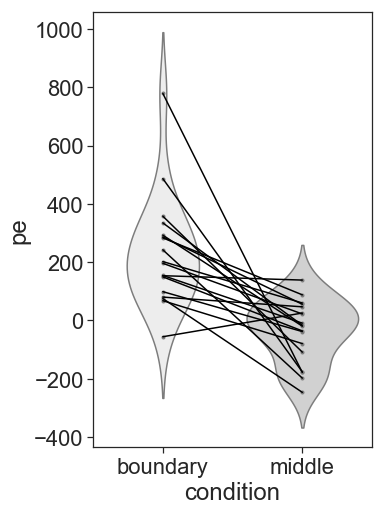

In [94]:
plt.figure(figsize=(5, 8))
sns.set(font_scale=2)
sns.set_style("ticks")
sns.set_palette('Greys')

figure = sns.lineplot(x = 'condition', y ='pe', data = hippo_pe_df[hippo_pe_df['movie']=='barmaid'][hippo_pe_df['mask']=='antHC'], estimator = None,units='subj_id',color = 'black')
sns.violinplot(x = 'condition', y ='pe', data = hippo_pe_df[hippo_pe_df['movie']=='barmaid'][hippo_pe_df['mask']=='antHC'],inner = 'points')


/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


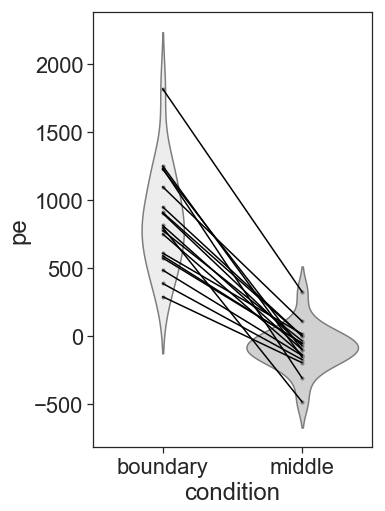

In [95]:
plt.figure(figsize=(5, 8))
sns.set(font_scale=2)
sns.set_style("ticks")
sns.set_palette('Greys')

figure = sns.lineplot(x = 'condition', y ='pe', data = hippo_pe_df[hippo_pe_df['movie']=='bluestreets'][hippo_pe_df['mask']=='postHC'], estimator = None,units='subj_id',color = 'black')
sns.violinplot(x = 'condition', y ='pe', data = hippo_pe_df[hippo_pe_df['movie']=='bluestreets'][hippo_pe_df['mask']=='postHC'],inner = 'points')


In [96]:
model = smf.mixedlm("pe~condition*mask",hippo_pe_df, groups='subj_id')
mdf = model.fit()
print(mdf.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          pe        
No. Observations:            144              Method:                      REML      
No. Groups:                  18               Scale:                       41930.8207
Min. group size:             8                Likelihood:                  -960.7626 
Max. group size:             8                Converged:                   Yes       
Mean group size:             8.0                                                     
-------------------------------------------------------------------------------------
                                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------------------
Intercept                            256.196   42.480   6.031 0.000  172.936  339.456
condition[T.middle]                 -292.896   48.265  -6.069 0.000 -387.493 -

In [97]:
sub_list = event_boundaries['subject'].unique()
movie_list = ['barmaid','bluestreets']
mask_list = ['antHC','postHC']

columns=['subject', 'movie', 'z','num_events_recalled','delay','length','roi']

num_events_recalled=[]
subject=[]
movie=[]
delay = []
length = []
roi = []
for k in range(len(mask_list)):
    for j in range (len(movie_list)):
        for i in range(len(sub_list)):
            num_events_recalled.append(event_boundaries[event_boundaries['subject']==sub_list[i]][event_boundaries['movie']==movie_list[j]]['recalled'].sum())
            subject.append(sub_list[i])
            movie.append(movie_list[j])
            roi.append(mask_list[k])
            delay.append(event_boundaries[event_boundaries['subject']==sub_list[i]][event_boundaries['movie']==movie_list[j]]['delay'].unique().item())
            length.append(event_boundaries[event_boundaries['subject']==sub_list[i]][event_boundaries['movie']==movie_list[j]]['end_seconds'].unique().sum())

/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [98]:
recall_and_boundary_data = np.array([subject,movie,z,num_events_recalled,delay,length,roi]).T
recall_and_boundary_df = pd.DataFrame(data = recall_and_boundary_data,columns=columns)
recall_and_boundary_df['z'] = recall_and_boundary_df['z'].astype('float64')
recall_and_boundary_df['num_events_recalled'] = recall_and_boundary_df['num_events_recalled'].astype('float64')


In [99]:
recall_and_boundary_df

,subject,movie,z,num_events_recalled,delay,length,roi
0,sub-000,barmaid,0.847319,10.0,immediate,746,antHC
1,sub-101,barmaid,0.575648,14.0,immediate,1639,antHC
2,sub-102,barmaid,0.673208,7.0,2day,449,antHC
3,sub-103,barmaid,0.110052,6.0,2day,270,antHC
4,sub-104,barmaid,0.523145,12.0,immediate,676,antHC
...,...,...,...,...,...,...,...
67,sub-119,bluestreets,2.593336,10.0,immediate,320,postHC
68,sub-120,bluestreets,1.878293,9.0,2day,790,postHC
69,sub-121,bluestreets,4.413544,12.0,2day,440,postHC
70,sub-123,bluestreets,1.606078,9.0,immediate,200,postHC


/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<Figure size 360x360 with 0 Axes>

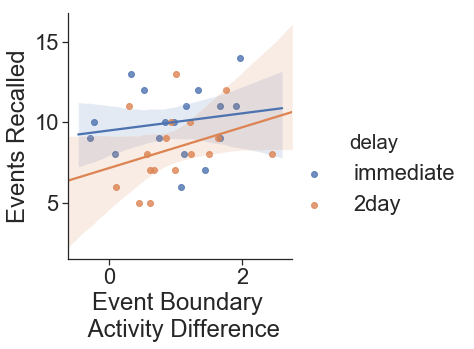

In [109]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=2)
sns.set_style("ticks")


figure = sns.lmplot(x = 'z', y = 'num_events_recalled',hue = 'delay',data = recall_and_boundary_df[recall_and_boundary_df['roi']=="antHC"])
figure.set(xlabel="Event Boundary \n Activity Difference", ylabel="Events Recalled")


#figure.savefig(analysis_dir+"boundary_recall_lmplot.pdf",dpi=300)

In [67]:
sub_list = hippo_pe_df['subj_id'].unique()
movie_list = ['barmaid','bluestreets']
mask_list = ['antHC','postHC']

beta_diff = []
num_events_recalled=[]
subject=[]
movie=[]
delay = []
length = []
mask = []
for i in range(len(sub_list)):
    for j in range (len(movie_list)):
        for k in range(len(mask_list)):
            num_events_recalled.append(event_boundaries[event_boundaries['subject']==sub_list[i]][event_boundaries['movie']==movie_list[j]]['recalled'].sum())
            subject.append(sub_list[i])
            mask.append(mask_list[k])
            movie.append(movie_list[j])
            delay.append(event_boundaries[event_boundaries['subject']==sub_list[i]][event_boundaries['movie']==movie_list[j]]['delay'].unique().item())
            length.append(event_boundaries[event_boundaries['subject']==sub_list[i]][event_boundaries['movie']==movie_list[j]]['end_seconds'].unique().sum())

            beta_diff.append(hippo_pe_df[hippo_pe_df['subj_id']==sub_list[i]][hippo_pe_df['movie']==movie_list[j]][hippo_pe_df['condition']=='boundary'][hippo_pe_df['mask']==mask_list[k]]['pe'].values.item() -hippo_pe_df[hippo_pe_df['subj_id']==sub_list[i]][hippo_pe_df['movie']==movie_list[j]][hippo_pe_df['condition']=='middle'][hippo_pe_df['mask']==mask_list[k]]['pe'].values.item())

/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/alexbarnett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [68]:
recall_and_boundary_data = pd.DataFrame(np.array([subject, movie,beta_diff, num_events_recalled,delay,length,mask]).T,columns=['subject', 'movie', 'beta_diff','num_events_recalled','delay','length','mask'])
recall_and_boundary_data['beta_diff']=recall_and_boundary_data['beta_diff'].astype("float64")
recall_and_boundary_data['num_events_recalled']=recall_and_boundary_data['num_events_recalled'].astype("float64")
recall_and_boundary_data['length']=recall_and_boundary_data['length'].astype("float64")

<Figure size 360x360 with 0 Axes>

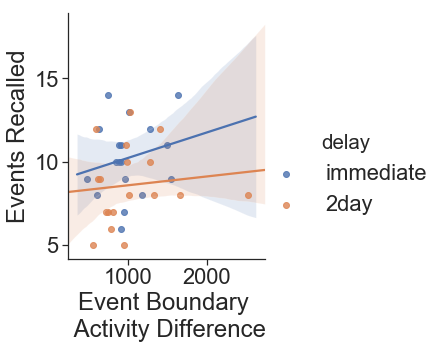

In [73]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=2)
sns.set_style("ticks")


figure = sns.lmplot(x = 'beta_diff', y = 'num_events_recalled',hue = 'delay',data = recall_and_boundary_data[recall_and_boundary_data['mask']=="postHC"])
figure.set(xlabel="Event Boundary \n Activity Difference", ylabel="Events Recalled")


#figure.savefig(analysis_dir+"boundary_recall_lmplot.pdf",dpi=300)